In [2]:
!pwd

/home/mkrishne/PL_competition


In [3]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import sys
print(sys.executable)

/home/mkrishne/default/bin/python3


In [5]:
import torch

# Check if CUDA is available (i.e., if a GPU is available)
is_cuda_available = torch.cuda.is_available()

if is_cuda_available:
    # Get the nsumber of available GPUs
    num_gpus = torch.cuda.device_count()
    
    print(f"CUDA is available. Number of GPUs: {num_gpus}")
    
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)} bytes")
        print(f"  Memory Reserved: {torch.cuda.memory_reserved(i)} bytes")  # updated line
else:
    print("CUDA is not available. No GPUs detected.")

CUDA is available. Number of GPUs: 2
GPU 0: NVIDIA L40S
  Memory Allocated: 0 bytes
  Memory Reserved: 0 bytes
GPU 1: NVIDIA L40S
  Memory Allocated: 0 bytes
  Memory Reserved: 0 bytes


In [6]:
!{sys.executable} -m pip install trimesh pyglet shapely pillow matplotlib scipy


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
import trimesh

# Load the mesh
tokyo_mesh = trimesh.load("a_3DMap_Data/buildings.obj")

# Show some infos
print(tokyo_mesh)

# Simple matplotlib 3D plot
#tokyo_mesh.show()

<trimesh.Trimesh(vertices.shape=(2564689, 3), faces.shape=(3170984, 3))>


In [8]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Load mesh
vertices = tokyo_mesh.vertices.copy()
faces = tokyo_mesh.faces

# Shift so xmin=ymin=0
xmin, ymin, zmin = vertices.min(axis=0)
xmax, ymax, zmax = vertices.max(axis=0)

shifted_vertices = vertices - np.array([xmin, ymin, 0])

# Scale X/Y/Z
scale_x = 1000.0 / shifted_vertices[:,0].max()
scale_y = 1000.0 / shifted_vertices[:,1].max()
scale_z = 100.0 / shifted_vertices[:,2].max()
scaled_vertices = shifted_vertices.copy()
scaled_vertices[:,0] *= scale_x
scaled_vertices[:,1] *= scale_y
scaled_vertices[:,2] *= scale_z

In [9]:
print(xmin, ymin, zmin)
print(xmax, ymax, zmax)

384592.1875 3944795.0 0.0
391455.15625 3952352.5 264.600006


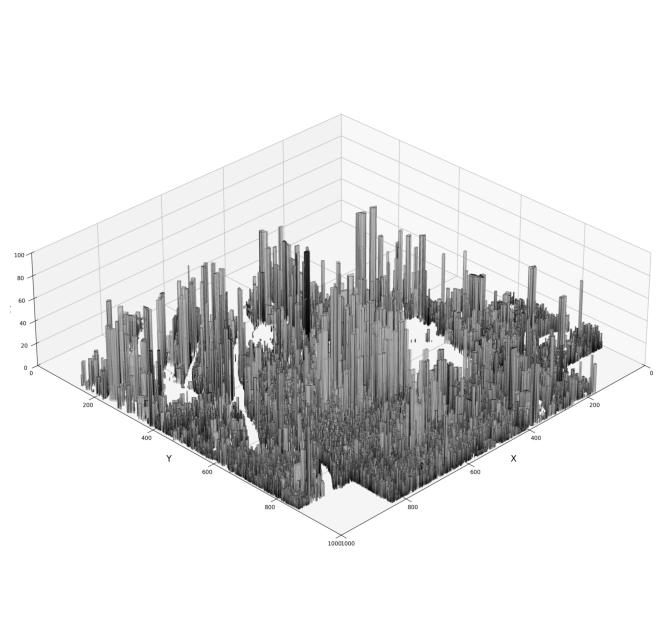

In [9]:
# Plot with matplotlib
fig = plt.figure(figsize=(25, 20), dpi=150)
ax = fig.add_subplot(111, projection='3d')

# Light gray with 30% opacity
ax.add_collection3d(Poly3DCollection(
    scaled_vertices[faces],
    facecolor=(0.7, 0.7, 0.7, 0.3),  # RGBA: light gray, 30% opacity
    edgecolor='k',
    linewidths=0.05
))

# Set axis limits
x, y, z = scaled_vertices[:,0], scaled_vertices[:,1], scaled_vertices[:,2]
ax.set_xlim(0, x.max())
ax.set_ylim(0, y.max())
ax.set_zlim(0, z.max())

# Labels and aspect
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
ax.set_zlabel('Z', fontsize=16)
ax.set_box_aspect([1, 1, 0.3])  # compress Z for city view
ax.view_init(elev=30, azim=45)

plt.savefig("a_3DMap_Data/tokyo_city_plot.png", bbox_inches='tight', dpi=300)
plt.show()

Reading CSV files...
  Processing 7GHz_Tx_1.csv
  Processing 7GHz_Tx_10.csv
  Processing 7GHz_Tx_11.csv
  Processing 7GHz_Tx_13.csv
  Processing 7GHz_Tx_15.csv
  Processing 7GHz_Tx_16.csv
  Processing 7GHz_Tx_17.csv
  Processing 7GHz_Tx_18.csv
  Processing 7GHz_Tx_19.csv
  Processing 7GHz_Tx_2.csv
  Processing 7GHz_Tx_3.csv
  Processing 7GHz_Tx_4.csv
  Processing 7GHz_Tx_6.csv
  Processing 7GHz_Tx_7.csv
  Processing 7GHz_Tx_8.csv
Total TX found: 15
Unique RX found: 182623
Shifting and scaling coordinates...
Coordinate transformation complete ✅
Plotting...


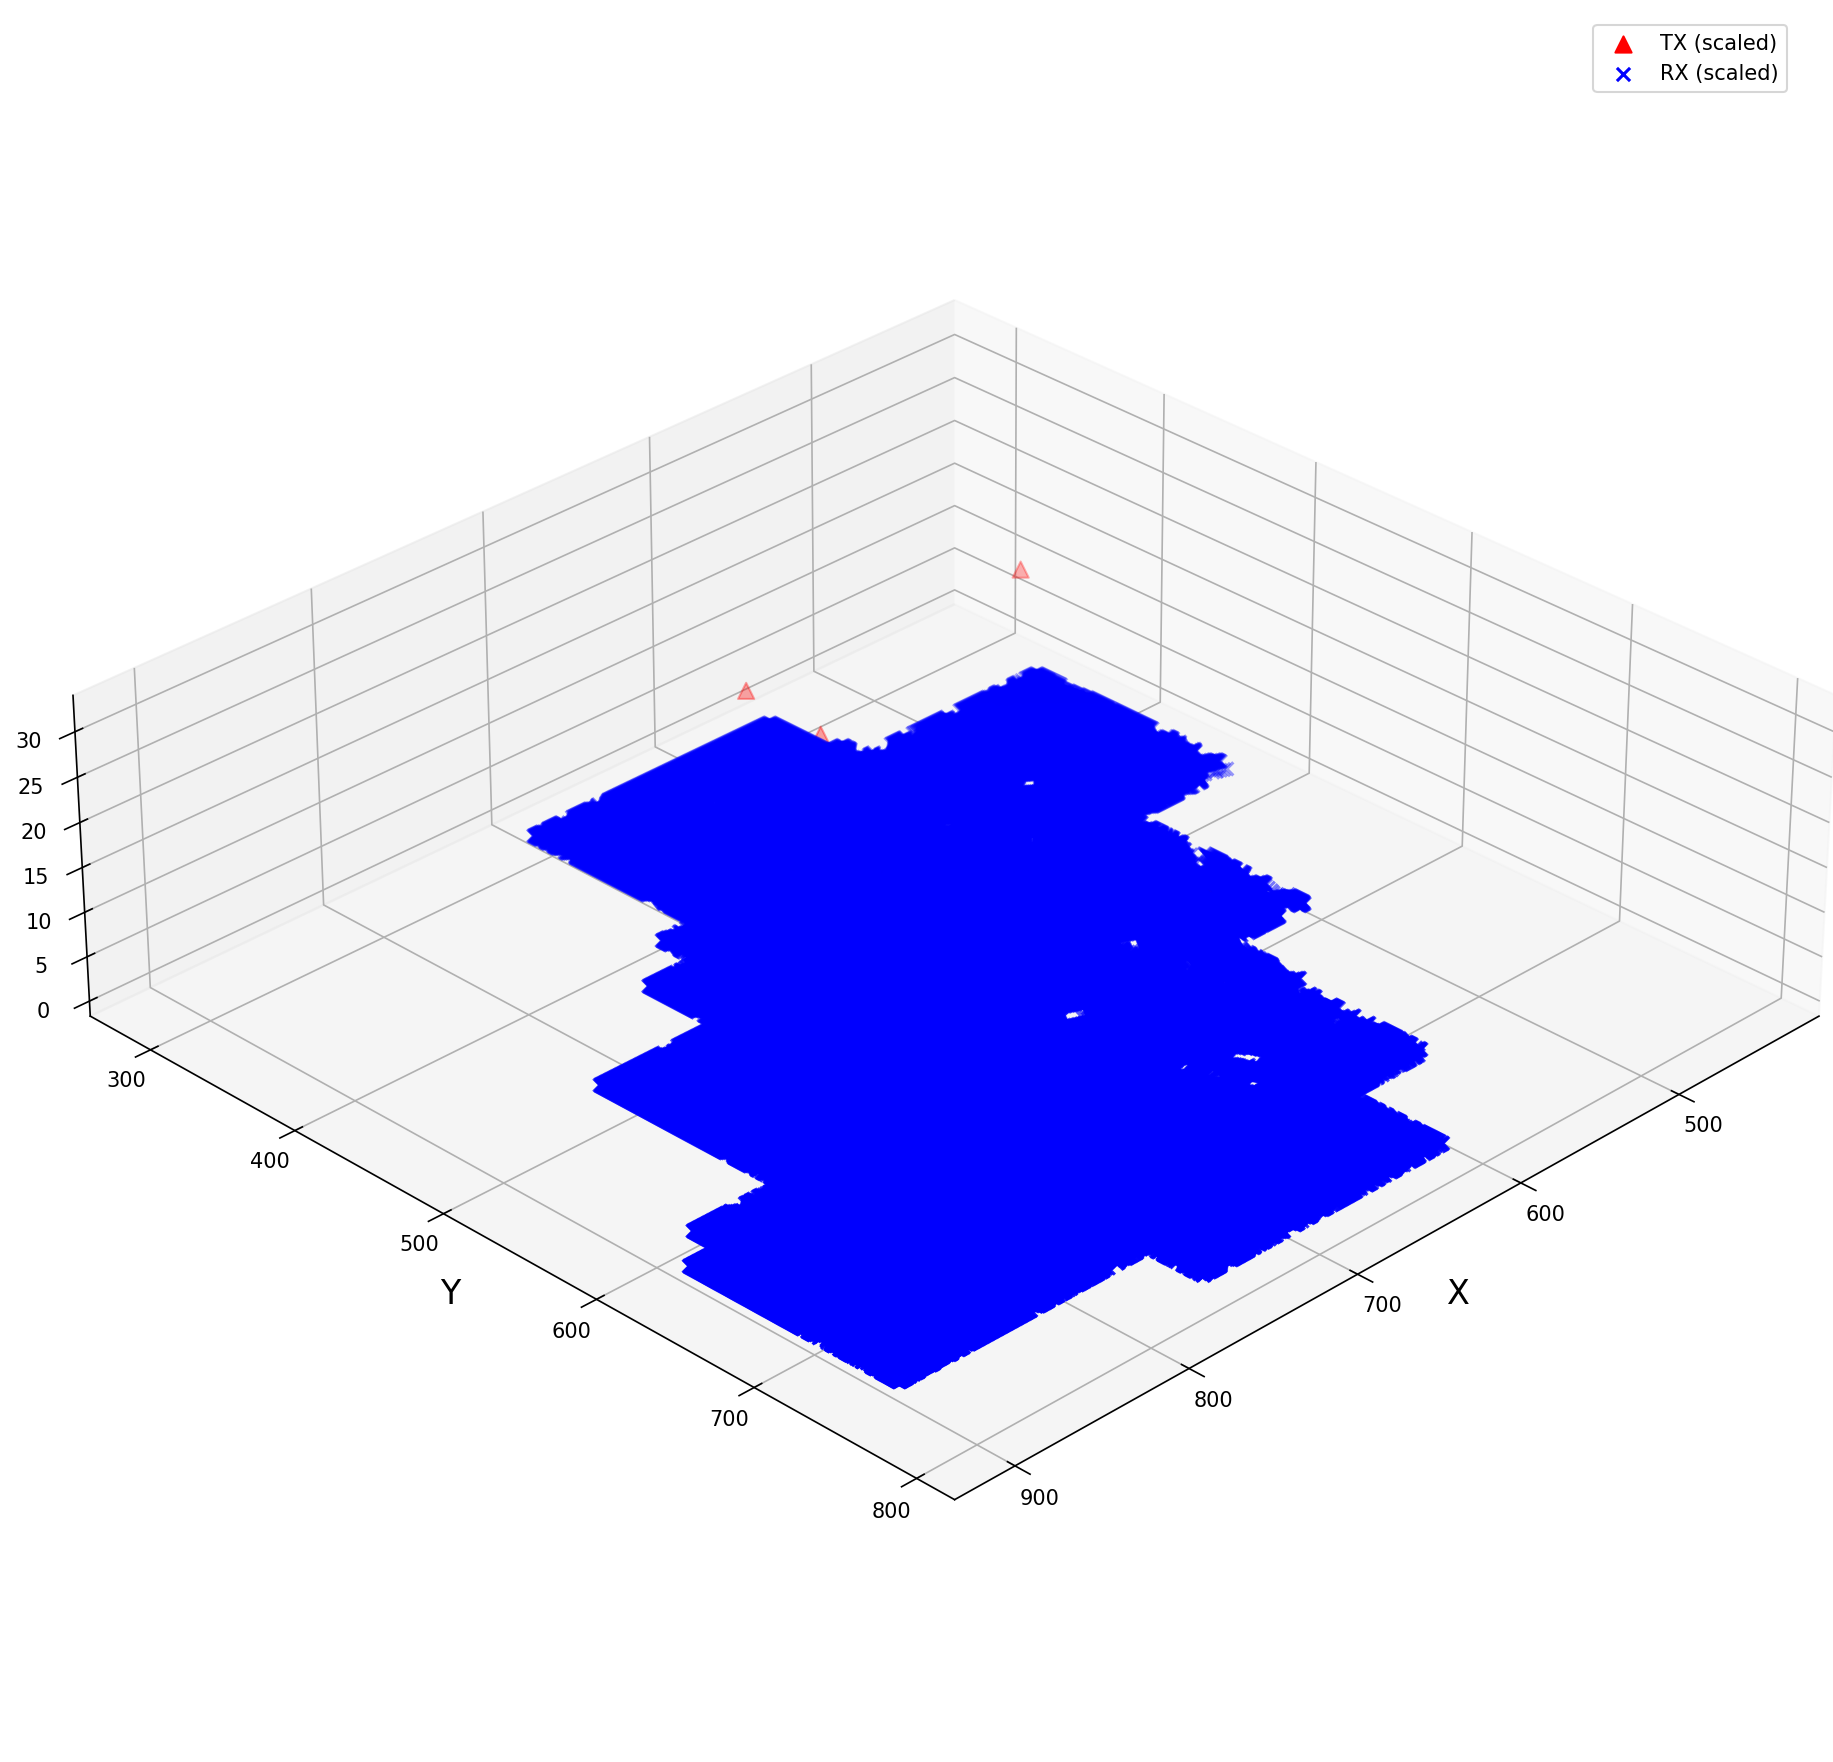

Done ✅


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Folder containing CSV files
csv_folder = Path("b_training_propagation_loss/7GHz")

# Initialize storage
tx_locations_raw = []   # TX before scaling/shift
rx_locations_raw = []   # RX before scaling/shift

print("Reading CSV files...")
for csv_file in csv_folder.glob("*.csv"):
    print(f"  Processing {csv_file.name}")
    df = pd.read_csv(csv_file)

    # TX: first row (x, y, z)
    tx = df.iloc[0, [0, 1, 2]].values
    tx_locations_raw.append(tx)

    # RX: all rows (x, y, z)
    rx_all = df.iloc[:, [6, 7, 8]]
    rx_locations_raw.append(rx_all.to_numpy())

# Combine all RX into one big array
rx_locations_raw = np.vstack(rx_locations_raw)

# Drop duplicates
rx_locations_raw = (
    pd.DataFrame(rx_locations_raw, columns=["x", "y", "z"])
    .drop_duplicates()
    .to_numpy()
)

# Convert TX list to array
tx_locations_raw = np.array(tx_locations_raw)

print(f"Total TX found: {len(tx_locations_raw)}")
print(f"Unique RX found: {len(rx_locations_raw)}")

# ------------------------------------------
# Shift and scale using mesh alignment
# ------------------------------------------

print("Shifting and scaling coordinates...")

# Shift x,y so that xmin=ymin=0 (from mesh precomputation)
tx_locations_shifted = tx_locations_raw.copy()
rx_locations_shifted = rx_locations_raw.copy()

tx_locations_shifted[:, 0] -= xmin
tx_locations_shifted[:, 1] -= ymin
rx_locations_shifted[:, 0] -= xmin
rx_locations_shifted[:, 1] -= ymin

# Scale (using same mesh scaling factors)
tx_locations_scaled = tx_locations_shifted.copy()
rx_locations_scaled = rx_locations_shifted.copy()

tx_locations_scaled[:, 0] *= scale_x
tx_locations_scaled[:, 1] *= scale_y
tx_locations_scaled[:, 2] *= scale_z

rx_locations_scaled[:, 0] *= scale_x
rx_locations_scaled[:, 1] *= scale_y
rx_locations_scaled[:, 2] *= scale_z

print("Coordinate transformation complete ✅")

# ------------------------------------------
# Plot scaled TX/RX points
# ------------------------------------------

print("Plotting...")

fig = plt.figure(figsize=(20, 15), dpi=150)
ax = fig.add_subplot(111, projection='3d')

# TX as red triangles
ax.scatter(tx_locations_scaled[:, 0], tx_locations_scaled[:, 1], tx_locations_scaled[:, 2],
           c='r', marker='^', s=60, label='TX (scaled)')

# RX as blue crosses
ax.scatter(rx_locations_scaled[:, 0], rx_locations_scaled[:, 1], rx_locations_scaled[:, 2],
           c='b', marker='x', s=40, label='RX (scaled)')

# Labels
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
ax.set_zlabel('Z', fontsize=16)
ax.set_box_aspect([1, 1, 0.3])
ax.view_init(elev=30, azim=45)
ax.legend()

# Save figure
output_path = "a_3DMap_Data/tx_rx_positions_scaled.png"
# plt.savefig(output_path, bbox_inches='tight', dpi=300)
# print(f"Plot saved to {output_path}")

plt.show()
print("Done ✅")

Plot saved to a_3DMap_Data/tx_positions_scaled_heatmap.png


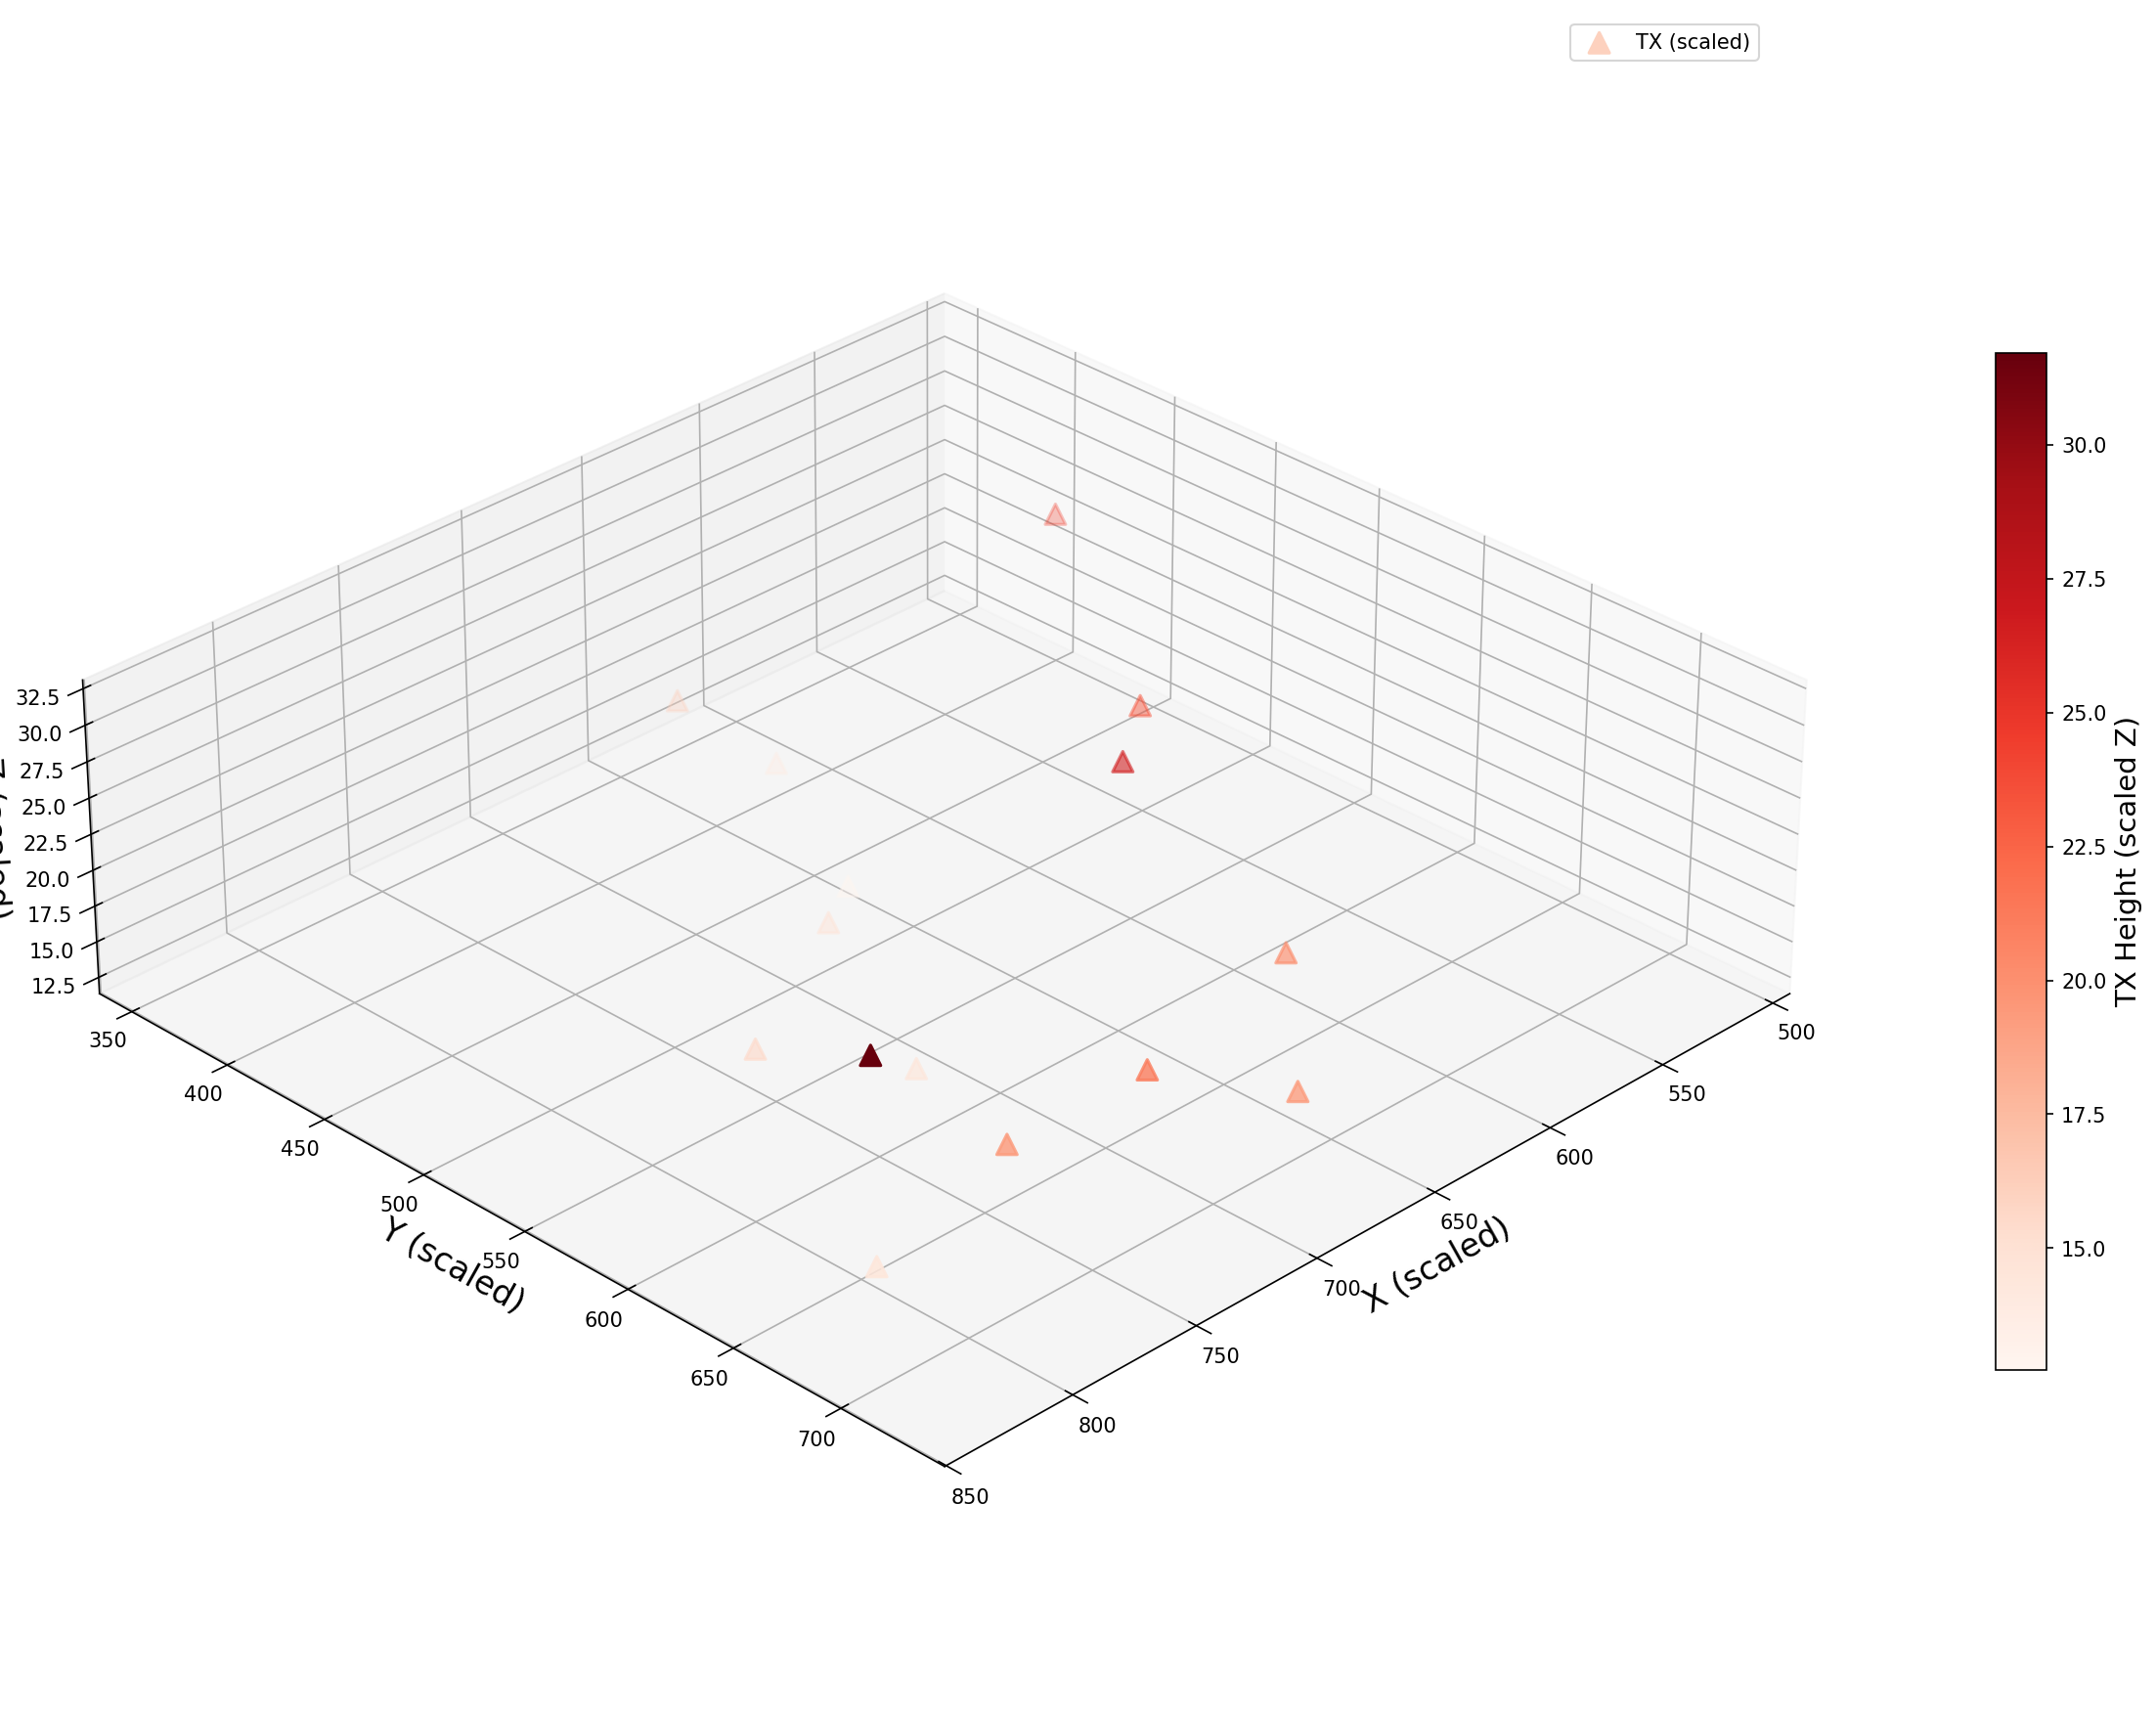

Done ✅


In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15), dpi=150)
ax = fig.add_subplot(111, projection='3d')

# TX points (scaled) colored by Z (height)
sc = ax.scatter(
    tx_locations_scaled[:, 0], tx_locations_scaled[:, 1], tx_locations_scaled[:, 2],
    c=tx_locations_scaled[:, 2],   # color based on scaled height
    cmap='Reds',
    marker='^',
    s=100,
    linewidths=1.5,
    label='TX (scaled)'
)

# Add colorbar to show height mapping
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('TX Height (scaled Z)', fontsize=14)

# Axis labels
ax.set_xlabel('X (scaled)', fontsize=16)
ax.set_ylabel('Y (scaled)', fontsize=16)
ax.set_zlabel('Z (scaled)', fontsize=16)

# Aspect ratio and view
ax.set_box_aspect([1, 1, 0.3])
ax.view_init(elev=30, azim=45)

# Legend
ax.legend()

# Save figure
output_path = "a_3DMap_Data/tx_positions_scaled_heatmap.png"
plt.savefig(output_path, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_path}")

# Show plot
plt.show()
print("Done ✅")

Plot saved to a_3DMap_Data/rx_positions_scaled_heatmap.png


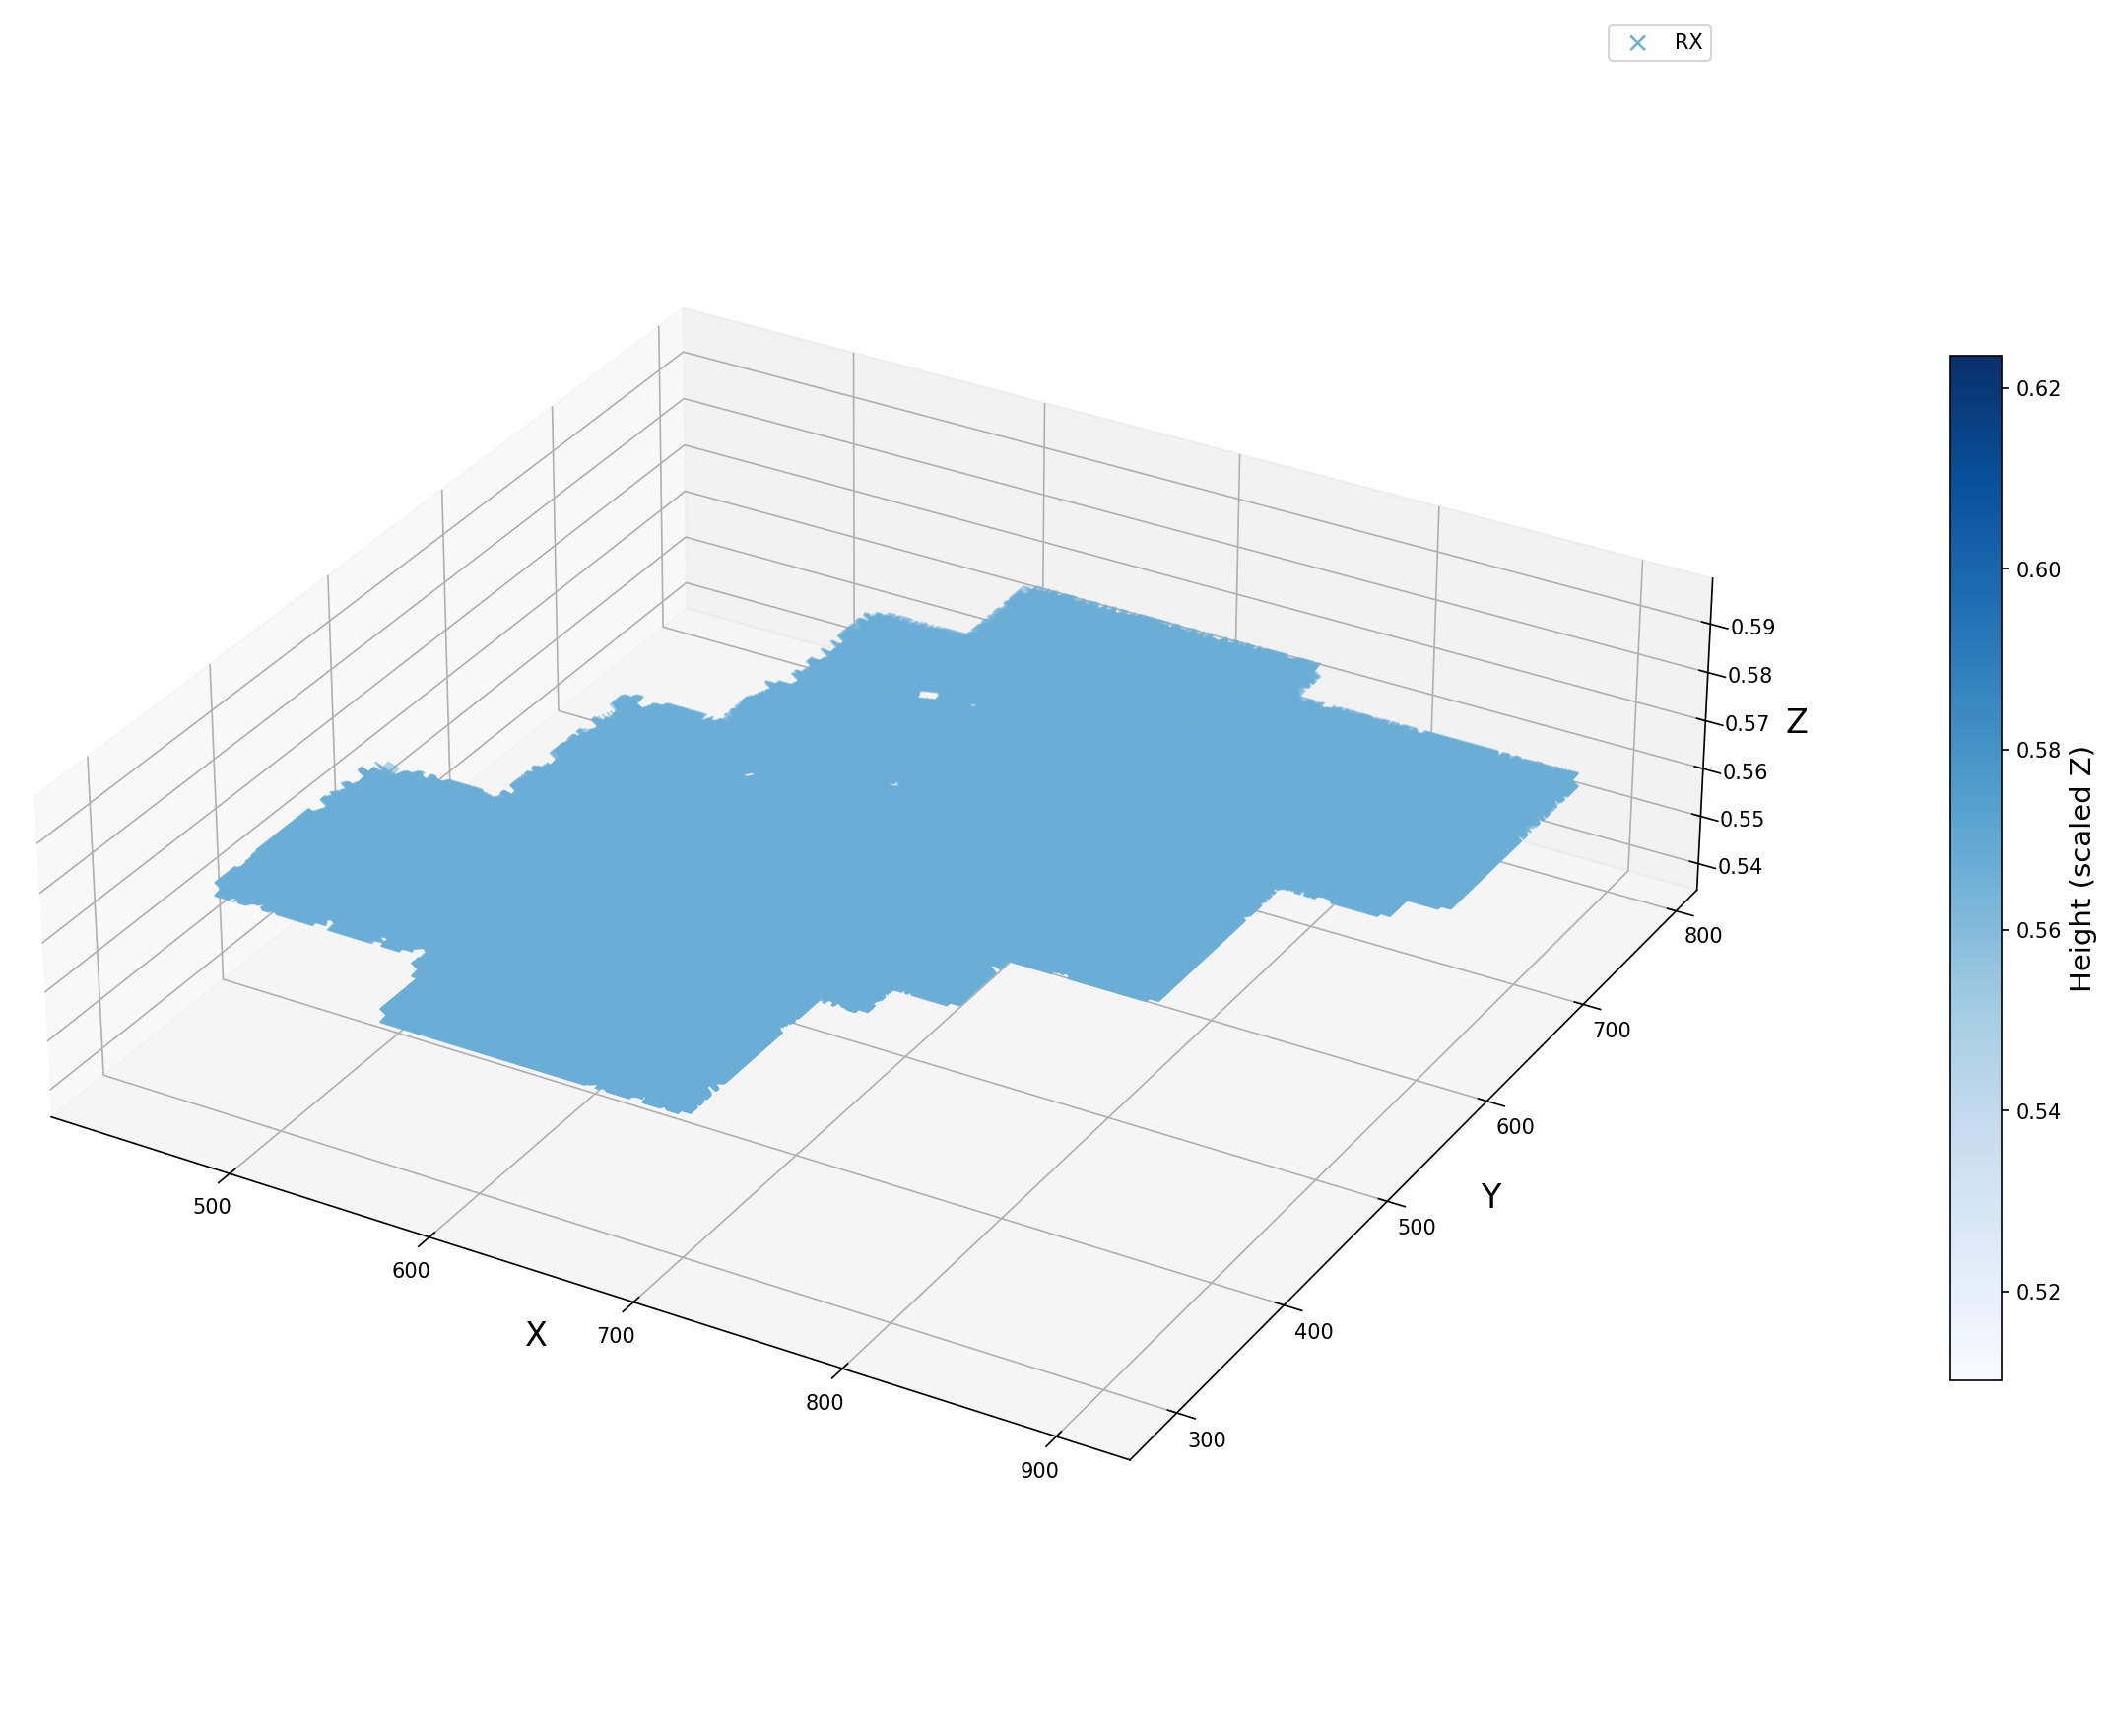

Done ✅


In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15), dpi=150)
ax = fig.add_subplot(111, projection='3d')

# RX points colored by scaled Z (height)
sc = ax.scatter(
    rx_locations_scaled[:, 0], rx_locations_scaled[:, 1], rx_locations_scaled[:, 2],
    c=rx_locations_scaled[:, 2],    # color based on scaled Z
    cmap='Blues',                   # blue colormap
    marker='x',
    s=50,
    linewidths=1.2,
    label='RX'
)

# Add colorbar to show height mapping
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('Height (scaled Z)', fontsize=14)

# Labels
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
ax.set_zlabel('Z', fontsize=16)

# Aspect ratio
ax.set_box_aspect([1, 1, 0.3])

# Legend
ax.legend()

# Save figure
output_path = "a_3DMap_Data/rx_positions_scaled_heatmap.png"
#plt.savefig(output_path, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_path}")

# Show plot
plt.show()
print("Done ✅")


/tmp/ipykernel_2835/3458367127.py:62: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(output_path, bbox_inches='tight', dpi=50)


Plot saved to a_3DMap_Data/tokyo_city_tx_rx_scaled.png


/home/mkrishne/default/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


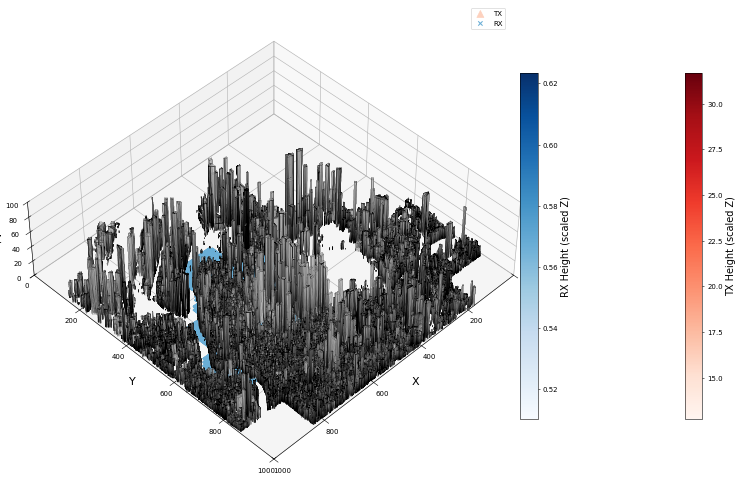

Done ✅


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Plot city mesh
fig = plt.figure(figsize=(20, 15), dpi=50)
ax = fig.add_subplot(111, projection='3d')

# Light gray city mesh with 30% opacity
ax.add_collection3d(Poly3DCollection(
    scaled_vertices[faces],
    facecolor=(0.7, 0.7, 0.7, 0.3),
    edgecolor='k',
    linewidths=0.05
))

# Set axis limits based on mesh
x, y, z = scaled_vertices[:, 0], scaled_vertices[:, 1], scaled_vertices[:, 2]
ax.set_xlim(0, x.max())
ax.set_ylim(0, y.max())
ax.set_zlim(0, z.max())

# TX points (scaled) colored by height
sc_tx = ax.scatter(
    tx_locations_scaled[:, 0], tx_locations_scaled[:, 1], tx_locations_scaled[:, 2],
    c=tx_locations_scaled[:, 2],
    cmap='Reds',
    marker='^',
    s=100,
    label='TX'
)

# RX points (scaled) colored by height
sc_rx = ax.scatter(
    rx_locations_scaled[:, 0], rx_locations_scaled[:, 1], rx_locations_scaled[:, 2],
    c=rx_locations_scaled[:, 2],
    cmap='Blues',
    marker='x',
    s=40,
    label='RX'
)

# Add colorbars
cbar_tx = plt.colorbar(sc_tx, ax=ax, shrink=0.6, pad=0.1)
cbar_tx.set_label('TX Height (scaled Z)', fontsize=14)

cbar_rx = plt.colorbar(sc_rx, ax=ax, shrink=0.6, pad=0.02)
cbar_rx.set_label('RX Height (scaled Z)', fontsize=14)

# Labels and aspect
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
ax.set_zlabel('Z', fontsize=16)
ax.set_box_aspect([1, 1, 0.3])
ax.view_init(elev=45, azim=45)

# Legend
ax.legend()

# Save figure
output_path = "a_3DMap_Data/tokyo_city_tx_rx_scaled.png"
plt.savefig(output_path, bbox_inches='tight', dpi=50)
print(f"Plot saved to {output_path}")

plt.show()
print("Done ✅")


Reading CSV files...
  Processing 7GHz_Tx_12.csv
  Processing 7GHz_Tx_14.csv
  Processing 7GHz_Tx_20.csv
  Processing 7GHz_Tx_5.csv
  Processing 7GHz_Tx_9.csv
Total TX test points found: 5
Unique RX test points found: 94453
Shifting coordinates...
Scaling coordinates...
Plotting test and train TX points...


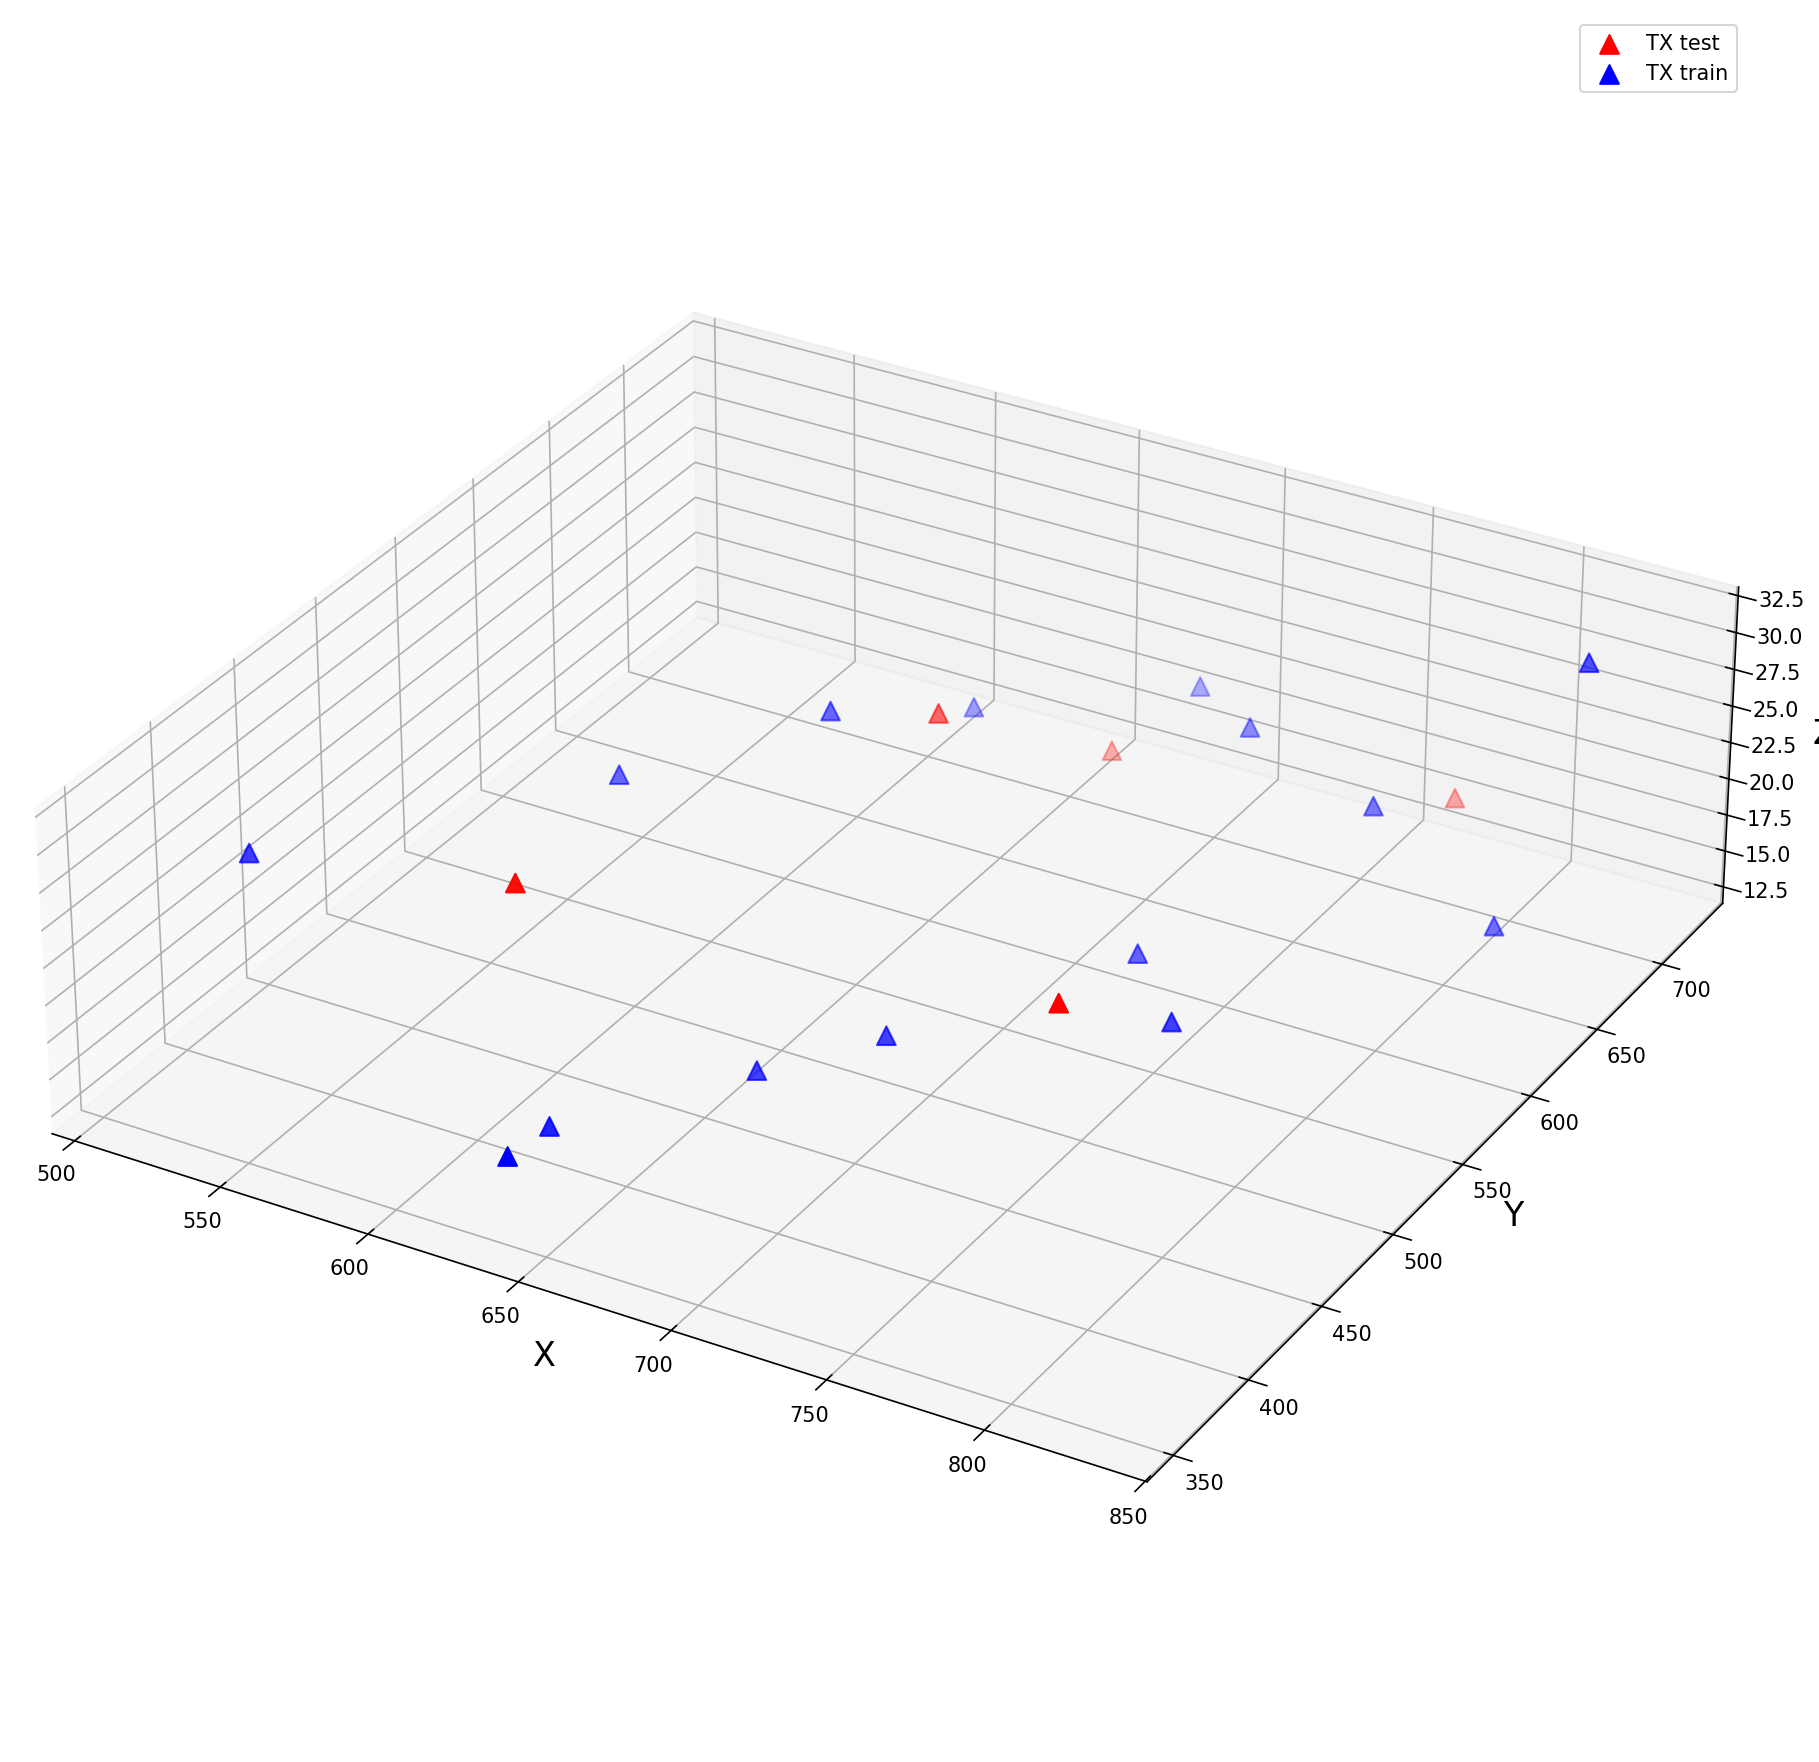

Done ✅


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Folder containing CSV files (test points)
csv_folder = Path("c_evaluation_propagation_loss/7GHz")

# Store TX and RX test point locations
tx_test_raw = []
rx_test_raw = []  # plain list

print("Reading CSV files...")
# Loop over CSV files
for csv_file in csv_folder.glob("*.csv"):
    print(f"  Processing {csv_file.name}")
    df = pd.read_csv(csv_file)

    # TX: first row, columns 0,1,2 (x,y,z)
    tx = df.iloc[0, [0, 1, 2]].values
    tx_test_raw.append(tx)

    # RX: all rows, columns 6,7,8 (x,y,z)
    rx_all = df.iloc[:, [6, 7, 8]]
    rx_test_raw.append(rx_all.to_numpy())

# Combine all RX into one big array
rx_test_raw = np.vstack(rx_test_raw)

# Drop duplicates
rx_test_raw = (
    pd.DataFrame(rx_test_raw, columns=["x", "y", "z"])
    .drop_duplicates()
    .to_numpy()
)

print(f"Total TX test points found: {len(tx_test_raw)}")
print(f"Unique RX test points found: {len(rx_test_raw)}")

# Convert TX to numpy
tx_test_raw = np.array(tx_test_raw)

print("Shifting coordinates...")
# Shifted coordinates
tx_test_shifted = tx_test_raw.copy()
rx_test_shifted = rx_test_raw.copy()

tx_test_shifted[:, 0] -= xmin
tx_test_shifted[:, 1] -= ymin
rx_test_shifted[:, 0] -= xmin
rx_test_shifted[:, 1] -= ymin

print("Scaling coordinates...")
# Scaled coordinates
tx_test_scaled = tx_test_shifted.copy()
rx_test_scaled = rx_test_shifted.copy()

tx_test_scaled[:, 0] *= scale_x
tx_test_scaled[:, 1] *= scale_y
tx_test_scaled[:, 2] *= scale_z

rx_test_scaled[:, 0] *= scale_x
rx_test_scaled[:, 1] *= scale_y
rx_test_scaled[:, 2] *= scale_z

print("Plotting test and train TX points...")
fig = plt.figure(figsize=(20, 15), dpi=150)
ax = fig.add_subplot(111, projection='3d')

# TX test points (red triangles)
ax.scatter(
    tx_test_scaled[:, 0], tx_test_scaled[:, 1], tx_test_scaled[:, 2],
    c='r', marker='^', s=80, label='TX test'
)

# TX train points (blue triangles)
ax.scatter(
    tx_locations_scaled[:, 0], tx_locations_scaled[:, 1], tx_locations_scaled[:, 2],
    c='b', marker='^', s=80, label='TX train'
)

# Optionally plot RX test points (commented out)
# ax.scatter(
#     rx_test_scaled[:, 0], rx_test_scaled[:, 1], rx_test_scaled[:, 2],
#     c='g', marker='x', s=40, label='RX test'
# )

# Labels and aspect
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
ax.set_zlabel('Z', fontsize=16)
ax.set_box_aspect([1, 1, 0.3])
ax.legend()

# Save figure
output_path = "a_3DMap_Data/test_tx_rx_positions_scaled.png"
# plt.savefig(output_path, bbox_inches='tight', dpi=300)
# print(f"Plot saved to {output_path}")

plt.show()
print("Done ✅")

=== Vertices of selected faces ===
[[598.37442798 124.61131326   1.17157972]
 [598.37442798 124.61131326   1.17157972]
 [598.37442798 124.61131326   1.17157972]
 ...
 [627.14750814  92.78862058   0.        ]
 [627.14750814  92.78862058   0.        ]
 [633.29462924  97.28746279   0.        ]]


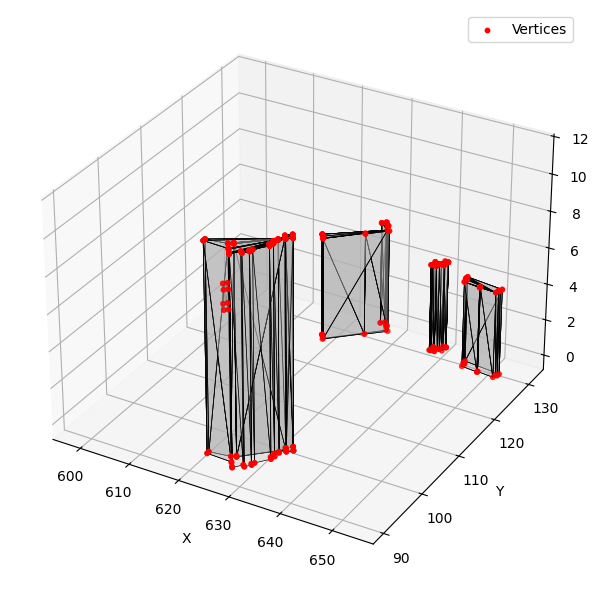

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Example: scaled_vertices and faces are already loaded
# scaled_vertices: (N, 3)
# faces: (M, 3) or (M, 4), containing vertex indices

# --- Select a smaller subset ---
num_faces_to_plot = 500  # you can increase to 5 or 10 for debugging
subset_faces = faces[:num_faces_to_plot]

# Get unique vertices that belong to these faces
unique_vertex_indices = np.unique(subset_faces)
subset_vertices = scaled_vertices[unique_vertex_indices]

print("=== Vertices of selected faces ===")
print(subset_vertices)

# --- Plot ---
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Reindex vertices for plotting (optional)
vertex_map = {old: new for new, old in enumerate(unique_vertex_indices)}
subset_faces_reindexed = np.vectorize(vertex_map.get)(subset_faces)

ax.add_collection3d(Poly3DCollection(
    subset_vertices[subset_faces_reindexed],
    facecolor=(0.7, 0.7, 0.7, 0.3),
    edgecolor='k',
    linewidths=0.5
))

ax.scatter(subset_vertices[:, 0], subset_vertices[:, 1], subset_vertices[:, 2],
           color='r', s=10, label='Vertices')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
import trimesh

# --- Compute building centroids (for shifted mesh) ---
face_centroids_shifted = shifted_vertices[faces].mean(axis=1)

# --- Define spatial window (example near city center) ---
x_range = (2500, 5500)
y_range = (2500, 5500)

# --- Select faces whose centroids lie inside the window ---
mask_shifted = (
    (face_centroids_shifted[:, 0] >= x_range[0]) & (face_centroids_shifted[:, 0] <= x_range[1]) &
    (face_centroids_shifted[:, 1] >= y_range[0]) & (face_centroids_shifted[:, 1] <= y_range[1])
)
subset_faces_shifted = faces[mask_shifted]

# --- Extract unique vertices for this subset ---
unique_subset_vertices_shifted = np.unique(subset_faces_shifted)
subset_vertices_shifted = shifted_vertices[unique_subset_vertices_shifted]

# --- Reindex faces to match the subset vertex array ---
vertex_reindex_shifted = {
    old_idx: new_idx for new_idx, old_idx in enumerate(unique_subset_vertices_shifted)
}
subset_faces_reindexed_shifted = np.vectorize(vertex_reindex_shifted.get)(subset_faces_shifted)

# --- Create a small trimesh ---
tokyo_small_mesh_shifted = trimesh.Trimesh(
    vertices=subset_vertices_shifted,
    faces=subset_faces_reindexed_shifted,
    process=False
)

print(f"Subset (shifted) mesh has {len(subset_vertices_shifted)} vertices and {len(subset_faces_reindexed_shifted)} faces.")

Subset (shifted) mesh has 527645 vertices and 648401 faces.


In [16]:
num_rx = 10
num_tx = 5
rx_sample = rx_locations_shifted[np.random.choice(len(rx_locations_shifted), num_rx, replace=False)]
tx_sample = tx_locations_shifted[np.random.choice(len(tx_locations_shifted), num_tx, replace=False)]

In [17]:
import numpy as np

los_matrix = np.zeros((num_rx, num_tx), dtype=bool)

for i, rx_pt in enumerate(rx_sample):
    for j, tx_pt in enumerate(tx_sample):
        ray_dir = tx_pt - rx_pt
        ray_len = np.linalg.norm(ray_dir)
        ray_dir /= ray_len

        locs, idx_ray, idx_tri = tokyo_small_mesh_shifted.ray.intersects_location(
            ray_origins=rx_pt[None, :],
            ray_directions=ray_dir[None, :]
        )

        los_matrix[i, j] = (
            len(locs) == 0 or np.linalg.norm(locs[0] - rx_pt) > ray_len
        )

        # --- Print for a few Rx–Tx pairs only ---
        if i < 5 and j < 5:  # adjust this to see more
            print(f"\n===== Rx {i} ↔ Tx {j} =====")
            print(f"Rx: {rx_pt}")
            print(f"Tx: {tx_pt}")
            print(f"Ray direction: {ray_dir}")
            print(f"Ray length: {ray_len:.3f}")
            print(f"Intersection count: {len(locs)}")
            if len(locs) > 0:
                print(f"Nearest intersection point: {locs[0]}")
                print(f"Distance to intersection: {np.linalg.norm(locs[0] - rx_pt):.3f}")
            print(f"Visible: {los_matrix[i, j]}")

    if i % 10 == 0:
        print(f"Processed {i}/{num_rx} Rx points.")



===== Rx 0 ↔ Tx 0 =====
Rx: [3.3403125e+03 2.7325000e+03 1.5000000e+00]
Tx: [5243.36477986 5109.66536661   51.1       ]
Ray direction: [0.62487644 0.78055377 0.0162864 ]
Ray length: 3045.486
Intersection count: 86
Nearest intersection point: [3981.9745152  3534.02118559   18.22388945]
Distance to intersection: 1026.862
Visible: False

===== Rx 0 ↔ Tx 1 =====
Rx: [3.3403125e+03 2.7325000e+03 1.5000000e+00]
Tx: [3976.42727986 4010.91536661   61.8       ]
Ray direction: [0.44508328 0.8944947  0.04219132]
Ray length: 1429.204
Intersection count: 44
Nearest intersection point: [3779.4316928  3615.00853717   43.12595834]
Distance to intersection: 986.600
Visible: False

===== Rx 0 ↔ Tx 2 =====
Rx: [3.3403125e+03 2.7325000e+03 1.5000000e+00]
Tx: [4981.08352986 4454.91536661   38.4       ]
Ray direction: [0.68965496 0.72397201 0.01550994]
Ray length: 2379.119
Intersection count: 58
Nearest intersection point: [4422.24154881 3868.26555494   25.83196416]
Distance to intersection: 1568.798
Visib

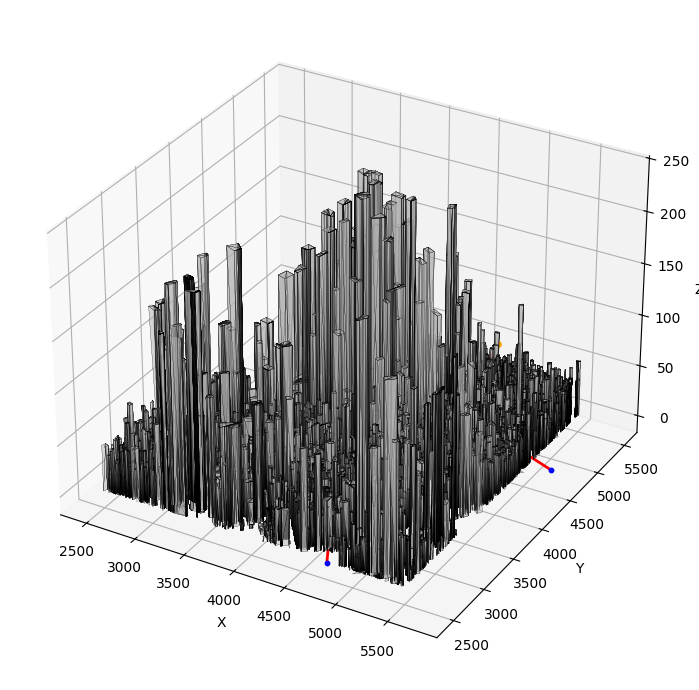

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot subset buildings

ax.add_collection3d(Poly3DCollection(
    subset_vertices_shifted[subset_faces_reindexed_shifted],
    facecolor=(0.7, 0.7, 0.7, 0.3),
    edgecolor='k',
    linewidths=0.1
))


# Plot a few Rx–Tx pairs
for idx in range(5):
    rx_pt = rx_sample[idx]
    tx_pt = tx_sample[idx % num_tx]
    color = 'g' if los_matrix[idx, idx % num_tx] else 'r'
    ax.plot(*zip(rx_pt, tx_pt), color=color, lw=2)
    ax.scatter(*rx_pt, color='b', s=10)
    ax.scatter(*tx_pt, color='orange', s=15)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()

In [19]:
# Combine Rx and Tx for bounding box
all_points = np.vstack([rx_locations_shifted, tx_locations_shifted])

min_bounds = all_points.min(axis=0)  # [xmin, ymin, zmin]
max_bounds = all_points.max(axis=0)  # [xmax, ymax, zmax]

print("Bounding box of Rx/Tx:")
print("Min:", min_bounds)
print("Max:", max_bounds)

Bounding box of Rx/Tx:
Min: [3.0353125e+03 2.2175000e+03 1.5000000e+00]
Max: [6180.3125 5947.5      83.9   ]


In [20]:
import numpy as np

# --- Full city mesh (shifted) ---
city_vertices_full = shifted_vertices
city_faces_full = faces

print(f"Original mesh has {len(city_vertices_full)} vertices and {len(city_faces_full)} faces.")

# Compute bounding box of the full city mesh
city_bbox_min = city_vertices_full.min(axis=0)
city_bbox_max = city_vertices_full.max(axis=0)

print("Full city mesh bounding box:")
print("Min:", city_bbox_min)
print("Max:", city_bbox_max)

# --- Compute bounding box of all Rx and Tx points ---
all_points = np.vstack([rx_locations_shifted, tx_locations_shifted])
rx_tx_bbox_min = all_points.min(axis=0)
rx_tx_bbox_max = all_points.max(axis=0)

print("Rx/Tx bounding box (XY only):")
print("Min (XY):", rx_tx_bbox_min[:2])
print("Max (XY):", rx_tx_bbox_max[:2])

# --- For each face, get its vertices ---
face_vertices_full = city_vertices_full[city_faces_full]  # shape: (num_faces, 3, 3)

# --- Boolean masks: inside and outside Rx–Tx XY bounding box ---
mask_inside = np.any(
    (face_vertices_full[:, :, 0] >= rx_tx_bbox_min[0]) &
    (face_vertices_full[:, :, 0] <= rx_tx_bbox_max[0]) &
    (face_vertices_full[:, :, 1] >= rx_tx_bbox_min[1]) &
    (face_vertices_full[:, :, 1] <= rx_tx_bbox_max[1]),
    axis=1
)
mask_outside = ~mask_inside

# ----------------- INSIDE MESH -----------------
city_faces_inside = city_faces_full[mask_inside]
unique_vertices_inside = np.unique(city_faces_inside)
city_vertices_inside = city_vertices_full[unique_vertices_inside]

# Reindex
vertex_reindex_inside = {old: new for new, old in enumerate(unique_vertices_inside)}
city_faces_inside_reindexed = np.vectorize(vertex_reindex_inside.get)(city_faces_inside)

print(f"Inside mesh has {len(city_vertices_inside)} vertices and {len(city_faces_inside_reindexed)} faces.")

# ----------------- OUTSIDE MESH -----------------
city_faces_outside = city_faces_full[mask_outside]
unique_vertices_outside = np.unique(city_faces_outside)
city_vertices_outside = city_vertices_full[unique_vertices_outside]

# Reindex
vertex_reindex_outside = {old: new for new, old in enumerate(unique_vertices_outside)}
city_faces_outside_reindexed = np.vectorize(vertex_reindex_outside.get)(city_faces_outside)

print(f"Outside mesh has {len(city_vertices_outside)} vertices and {len(city_faces_outside_reindexed)} faces.")

# --- Shared plot helpers precomputed here ---
bbox_x = [rx_tx_bbox_min[0], rx_tx_bbox_max[0]]
bbox_y = [rx_tx_bbox_min[1], rx_tx_bbox_max[1]]
z_level = float(np.mean(city_vertices_full[:, 2]))

Original mesh has 2564689 vertices and 3170984 faces.
Full city mesh bounding box:
Min: [0. 0. 0.]
Max: [6862.96875  7557.5       264.600006]
Rx/Tx bounding box (XY only):
Min (XY): [3035.3125 2217.5   ]
Max (XY): [6180.3125 5947.5   ]
Inside mesh has 829663 vertices and 1024496 faces.
Outside mesh has 1735576 vertices and 2146488 faces.


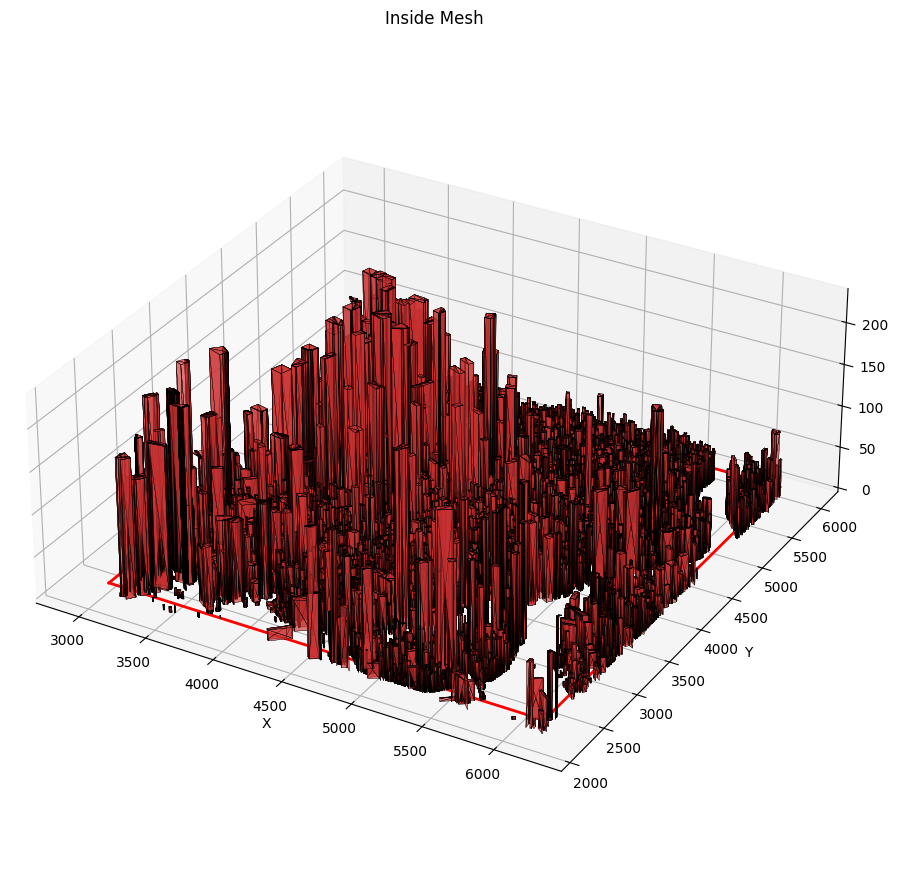

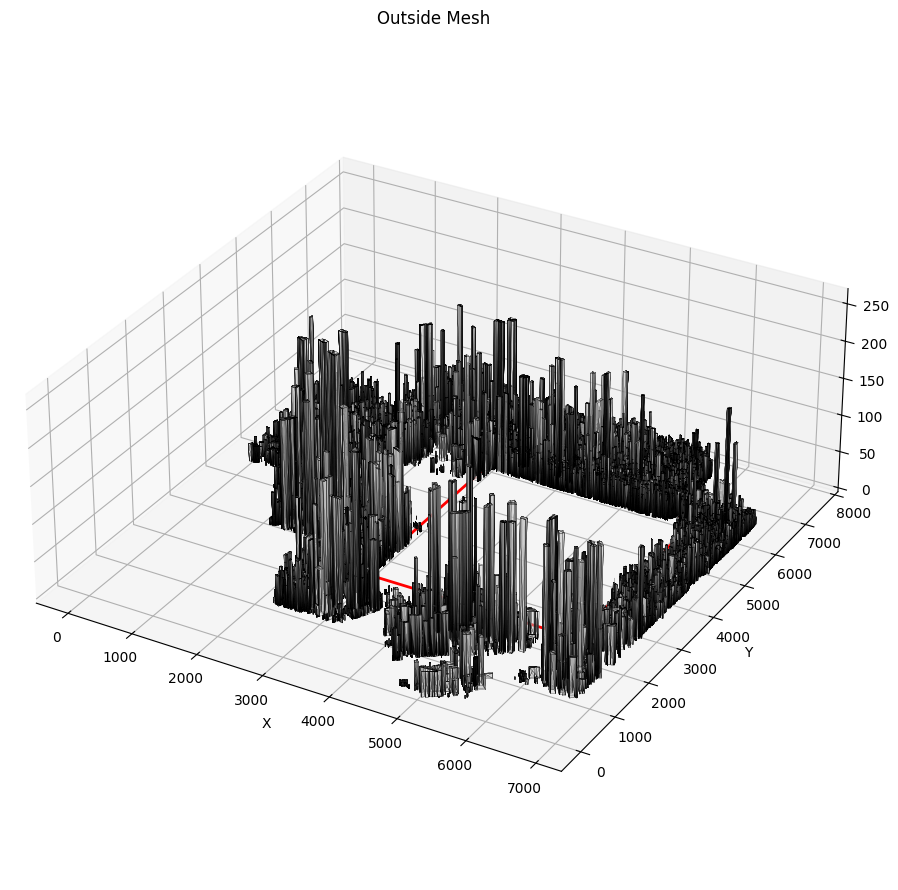

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ----------------- Plot inside mesh -----------------
fig_in = plt.figure(figsize=(10, 9))
ax_in = fig_in.add_subplot(111, projection='3d')
if len(city_faces_inside_reindexed):
    ax_in.add_collection3d(Poly3DCollection(
        city_vertices_inside[city_faces_inside_reindexed],
        facecolor=(0.8, 0.2, 0.2, 0.4),   # reddish tint
        edgecolor='k',
        linewidths=0.2
    ))
# Draw bounding box
ax_in.plot([bbox_x[0], bbox_x[1]], [bbox_y[0], bbox_y[0]], zs=z_level, color='r', lw=2)
ax_in.plot([bbox_x[1], bbox_x[1]], [bbox_y[0], bbox_y[1]], zs=z_level, color='r', lw=2)
ax_in.plot([bbox_x[1], bbox_x[0]], [bbox_y[1], bbox_y[1]], zs=z_level, color='r', lw=2)
ax_in.plot([bbox_x[0], bbox_x[0]], [bbox_y[1], bbox_y[0]], zs=z_level, color='r', lw=2)
ax_in.set_xlabel('X'); ax_in.set_ylabel('Y'); ax_in.set_zlabel('Z')
ax_in.set_title("Inside Mesh")
ax_in.set_box_aspect([1,1,0.4])
plt.tight_layout()
plt.show()

# ----------------- Plot outside mesh -----------------
fig_out = plt.figure(figsize=(10, 9))
ax_out = fig_out.add_subplot(111, projection='3d')
if len(city_faces_outside_reindexed):
    ax_out.add_collection3d(Poly3DCollection(
        city_vertices_outside[city_faces_outside_reindexed],
        facecolor=(0.8, 0.8, 0.8, 0.25),   # greyish tint
        edgecolor='k',
        linewidths=0.1
    ))
# Draw bounding box for reference
ax_out.plot([bbox_x[0], bbox_x[1]], [bbox_y[0], bbox_y[0]], zs=z_level, color='r', lw=2)
ax_out.plot([bbox_x[1], bbox_x[1]], [bbox_y[0], bbox_y[1]], zs=z_level, color='r', lw=2)
ax_out.plot([bbox_x[1], bbox_x[0]], [bbox_y[1], bbox_y[1]], zs=z_level, color='r', lw=2)
ax_out.plot([bbox_x[0], bbox_x[0]], [bbox_y[1], bbox_y[0]], zs=z_level, color='r', lw=2)
ax_out.set_xlabel('X'); ax_out.set_ylabel('Y'); ax_out.set_zlabel('Z')
ax_out.set_title("Outside Mesh")
ax_out.set_box_aspect([1,1,0.4])
plt.tight_layout()
plt.show()

In [22]:
# --- Recover original coordinates for inside vertices ---
utm_x_min_inside_bbox = rx_tx_bbox_min[0] + xmin
utm_x_max_inside_bbox = rx_tx_bbox_max[0] + xmin
utm_y_min_inside_bbox = rx_tx_bbox_min[1] + ymin
utm_y_max_inside_bbox = rx_tx_bbox_max[1] + ymin
print("Inside mesh UTM bounding box:")
print(f"X min: {utm_x_min_inside_bbox}, X max: {utm_x_max_inside_bbox}")
print(f"Y min: {utm_y_min_inside_bbox}, Y max: {utm_y_max_inside_bbox}")

Inside mesh UTM bounding box:
X min: 387627.5, X max: 390772.5
Y min: 3947012.5, Y max: 3950742.5


In [23]:
from pyproj import Proj, Transformer

# Define UTM projection (zone 54N)
utm_proj = Proj(proj='utm', zone=54, ellps='WGS84', south=False)
wgs84_proj = Proj(proj='latlong', datum='WGS84')

# Or use Transformer (better)
transformer = Transformer.from_crs(f"+proj=utm +zone=54 +datum=WGS84 +units=m +no_defs",
                                   "EPSG:4326", always_xy=True)

# Coordinates
x1, y1 = utm_x_min_inside_bbox, utm_y_min_inside_bbox
x2, y2 = utm_x_max_inside_bbox, utm_y_max_inside_bbox

# Convert
x_min_inside_lon1, x_min_inside_lat1 = transformer.transform(x1, y1)
x_min_inside_lon2, x_min_inside_lat2 = transformer.transform(x2, y2)

print(f"Point 1: Latitude {x_min_inside_lat1}, Longitude {x_min_inside_lon1}")
print(f"Point 2: Latitude {x_min_inside_lat2}, Longitude {x_min_inside_lon2}")

Point 1: Latitude 35.66057825471421, Longitude 139.7585143007345
Point 2: Latitude 35.694555217482815, Longitude 139.7927467148492


In [24]:
from pyproj import Transformer
import numpy as np

# --- 1. Compute current extent in meters ---
extent_x = abs(utm_x_max_inside_bbox - utm_x_min_inside_bbox)
extent_y = abs(utm_y_max_inside_bbox - utm_y_min_inside_bbox)
print(f"Original extent (meters): East-West = {extent_x:.2f}, North-South = {extent_y:.2f}")

# --- 2. Extend bounding box by 200m in all directions ---
extension = 500  # meters
utm_x_min_extended = utm_x_min_inside_bbox - extension
utm_x_max_extended = utm_x_max_inside_bbox + extension
utm_y_min_extended = utm_y_min_inside_bbox - extension
utm_y_max_extended = utm_y_max_inside_bbox + extension

# --- Convert extended UTM corners to lat/lon ---
transformer = Transformer.from_crs(
    f"+proj=utm +zone=54 +datum=WGS84 +units=m +no_defs",
    "EPSG:4326",
    always_xy=True
)

lon_min_extended, lat_min_extended = transformer.transform(utm_x_min_extended, utm_y_min_extended)
lon_max_extended, lat_max_extended = transformer.transform(utm_x_max_extended, utm_y_max_extended)

print("\nExtended bounding box (UTM):")
print(f"X min: {utm_x_min_extended}, X max: {utm_x_max_extended}")
print(f"Y min: {utm_y_min_extended}, Y max: {utm_y_max_extended}")

print("\nExtended bounding box (Lat/Lon):")
print(f"Point 1 (min corner): Latitude {lat_min_extended}, Longitude {lon_min_extended}")
print(f"Point 2 (max corner): Latitude {lat_max_extended}, Longitude {lon_max_extended}")

# --- 3. Compute new extent in meters ---
extent_x_extended = abs(utm_x_max_extended - utm_x_min_extended)
extent_y_extended = abs(utm_y_max_extended - utm_y_min_extended)
print(f"\nExtended extent (meters): East-West = {extent_x_extended:.2f}, North-South = {extent_y_extended:.2f}")

Original extent (meters): East-West = 3145.00, North-South = 3730.00

Extended bounding box (UTM):
X min: 387127.5, X max: 391272.5
Y min: 3946512.5, Y max: 3951242.5

Extended bounding box (Lat/Lon):
Point 1 (min corner): Latitude 35.65601402610405, Longitude 139.75306157263827
Point 2 (max corner): Latitude 35.699117715538016, Longitude 139.79820431501943

Extended extent (meters): East-West = 4145.00, North-South = 4730.00


In [25]:
# PREP CELL (no plotting) ---------------------------------------------
import numpy as np

# --- Full city mesh (shifted) ---
city_vertices_full = shifted_vertices
city_faces_full = faces

# --- Compute extended bounding boxes (shifted) ---
utm_x_min_extended_shifted = utm_x_min_extended - xmin
utm_x_max_extended_shifted = utm_x_max_extended - xmin
utm_y_min_extended_shifted = utm_y_min_extended - ymin
utm_y_max_extended_shifted = utm_y_max_extended - ymin

# --- For each face, get its vertices ---
face_vertices_full = city_vertices_full[city_faces_full]  # shape: (num_faces, 3, 3)

# --- Mask faces inside extended bounding box (shifted) ---
mask_extended = np.any(
    (face_vertices_full[:, :, 0] >= utm_x_min_extended_shifted) &
    (face_vertices_full[:, :, 0] <= utm_x_max_extended_shifted) &
    (face_vertices_full[:, :, 1] >= utm_y_min_extended_shifted) &
    (face_vertices_full[:, :, 1] <= utm_y_max_extended_shifted),
    axis=1
)
faces_extended = city_faces_full[mask_extended]
print(f"Faces inside extended bounding box: {len(faces_extended)}")

# --- Mask faces inside original bounding box (subset of extended) ---
mask_inside = np.any(
    (face_vertices_full[:, :, 0] >= rx_tx_bbox_min[0]) &
    (face_vertices_full[:, :, 0] <= rx_tx_bbox_max[0]) &
    (face_vertices_full[:, :, 1] >= rx_tx_bbox_min[1]) &
    (face_vertices_full[:, :, 1] <= rx_tx_bbox_max[1]),
    axis=1
)
faces_red = city_faces_full[mask_inside & mask_extended]  # inside original bbox

# faces_grey = (outside original, inside extended)
faces_grey = np.setdiff1d(
    faces_extended.view([('', faces_extended.dtype)] * faces_extended.shape[1]),
    faces_red.view([('', faces_red.dtype)] * faces_red.shape[1])
).view(faces_extended.dtype).reshape(-1, 3)

print(f"Grey faces (outside original, inside extended): {len(faces_grey)}")
print(f"Red faces (inside original bounding box): {len(faces_red)}")

# --- Reindex vertices for plotting ---
unique_vertices_grey = np.unique(faces_grey)
unique_vertices_red  = np.unique(faces_red)

vertex_map_grey = {old: new for new, old in enumerate(unique_vertices_grey)}
faces_grey_reindexed = np.vectorize(vertex_map_grey.get)(faces_grey)

vertex_map_red = {old: new for new, old in enumerate(unique_vertices_red)}
faces_red_reindexed = np.vectorize(vertex_map_red.get)(faces_red)

vertices_grey_shifted = city_vertices_full[unique_vertices_grey]
vertices_red_shifted  = city_vertices_full[unique_vertices_red]

print(f"Unique vertices for grey faces: {len(unique_vertices_grey)}")
print(f"Unique vertices for red faces: {len(unique_vertices_red)}")

# --- Height for plotting bounding boxes ---
z_level = float(np.mean(vertices_grey_shifted[:, 2])) if len(vertices_grey_shifted) else 0.0

# --- Precompute simple bbox arrays used by the plot cell ---
bbox_x     = [rx_tx_bbox_min[0], rx_tx_bbox_max[0]]     # fixed small typo from earlier line break
bbox_y     = [rx_tx_bbox_min[1], rx_tx_bbox_max[1]]
bbox_x_ext = [utm_x_min_extended_shifted, utm_x_max_extended_shifted]
bbox_y_ext = [utm_y_min_extended_shifted, utm_y_max_extended_shifted]


Faces inside extended bounding box: 1724880
Grey faces (outside original, inside extended): 405764
Red faces (inside original bounding box): 1024496
Unique vertices for grey faces: 567549
Unique vertices for red faces: 829663


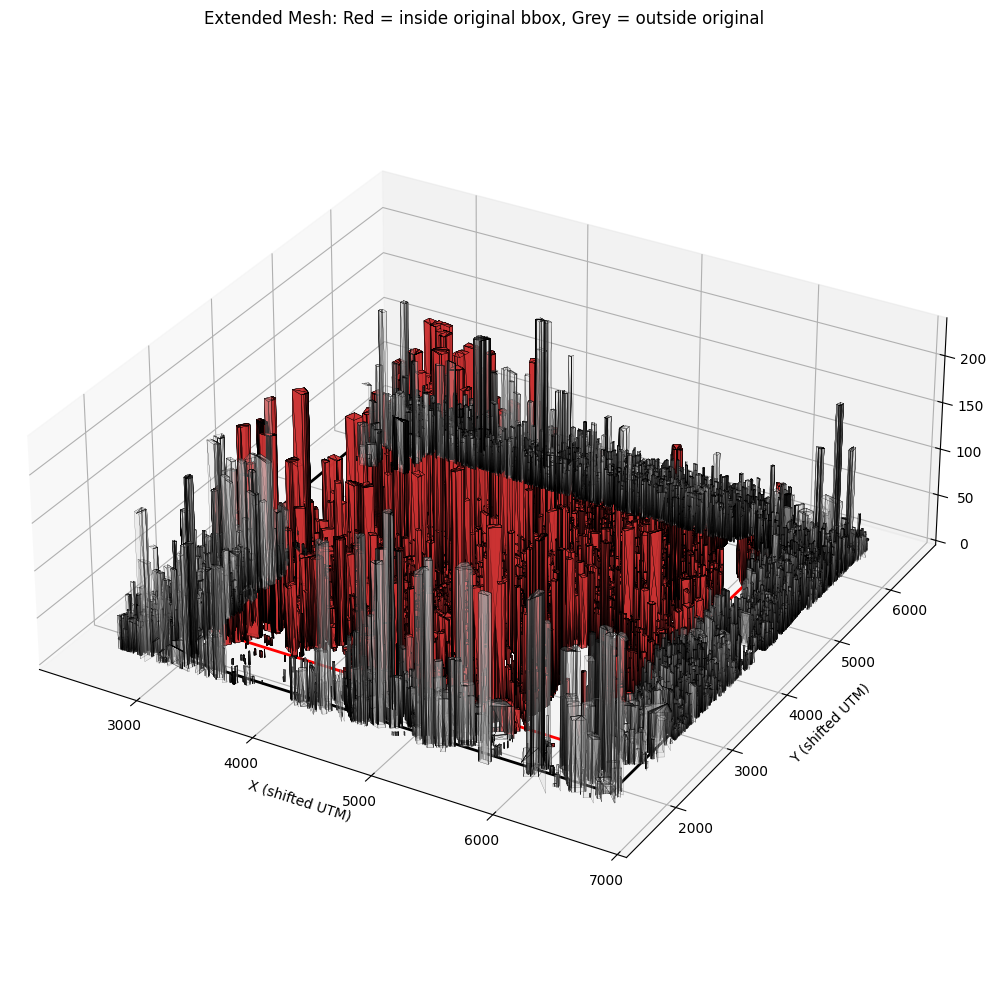

In [26]:
# PLOT CELL (can be skipped) ------------------------------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Grey faces (outside original, inside extended)
if len(faces_grey_reindexed):
    ax.add_collection3d(Poly3DCollection(
        vertices_grey_shifted[faces_grey_reindexed],
        facecolor=(0.8, 0.8, 0.8, 0.25),   # greyish
        edgecolor='k',
        linewidths=0.1
    ))

# Red faces (inside original bounding box)
if len(faces_red_reindexed):
    ax.add_collection3d(Poly3DCollection(
        vertices_red_shifted[faces_red_reindexed],
        facecolor=(0.8, 0.2, 0.2, 0.6),    # red
        edgecolor='k',
        linewidths=0.2
    ))

# Draw original bounding box (red)
ax.plot([bbox_x[0], bbox_x[1]], [bbox_y[0], bbox_y[0]], zs=z_level, color='r', lw=2)
ax.plot([bbox_x[1], bbox_x[1]], [bbox_y[0], bbox_y[1]], zs=z_level, color='r', lw=2)
ax.plot([bbox_x[1], bbox_x[0]], [bbox_y[1], bbox_y[1]], zs=z_level, color='r', lw=2)
ax.plot([bbox_x[0], bbox_x[0]], [bbox_y[1], bbox_y[0]], zs=z_level, color='r', lw=2)

# Draw extended bounding box (grey)
ax.plot([bbox_x_ext[0], bbox_x_ext[1]], [bbox_y_ext[0], bbox_y_ext[0]], zs=z_level, color='k', lw=2)
ax.plot([bbox_x_ext[1], bbox_x_ext[1]], [bbox_y_ext[0], bbox_y_ext[1]], zs=z_level, color='k', lw=2)
ax.plot([bbox_x_ext[1], bbox_x_ext[0]], [bbox_y_ext[1], bbox_y_ext[1]], zs=z_level, color='k', lw=2)
ax.plot([bbox_x_ext[0], bbox_x_ext[0]], [bbox_y_ext[1], bbox_y_ext[0]], zs=z_level, color='k', lw=2)

# Labels
ax.set_xlabel('X (shifted UTM)')
ax.set_ylabel('Y (shifted UTM)')
ax.set_zlabel('Z')
ax.set_title("Extended Mesh: Red = inside original bbox, Grey = outside original")
ax.set_box_aspect([1, 1, 0.4])
plt.tight_layout()
plt.show()

In [27]:
# --- Faces inside the extended bbox (you already have mask_extended) ---
faces_extended = city_faces_full[mask_extended]               # (K, 3) int

# --- Unique vertex indices used by those faces ---
unique_vertices_extended = np.unique(faces_extended.ravel())  # (U,)

# --- Build an old->new index map and reindex faces ---
new_index = -np.ones(city_vertices_full.shape[0], dtype=int)
new_index[unique_vertices_extended] = np.arange(unique_vertices_extended.size)

city_faces_extended_shifted = new_index[faces_extended]       # (K, 3) int (reindexed)

# --- Slice vertex array to only used vertices (shifted coords you already have) ---
city_vertices_extended_shifted = city_vertices_full[unique_vertices_extended]  # (U, 3) float

print("city_vertices_extended_shifted:", city_vertices_extended_shifted.shape)
print("city_faces_extended_shifted:", city_faces_extended_shifted.shape)

city_vertices_extended_shifted: (1396662, 3)
city_faces_extended_shifted: (1724880, 3)


Faces intersecting 1st Fresnel zone: 1397 / 1724880


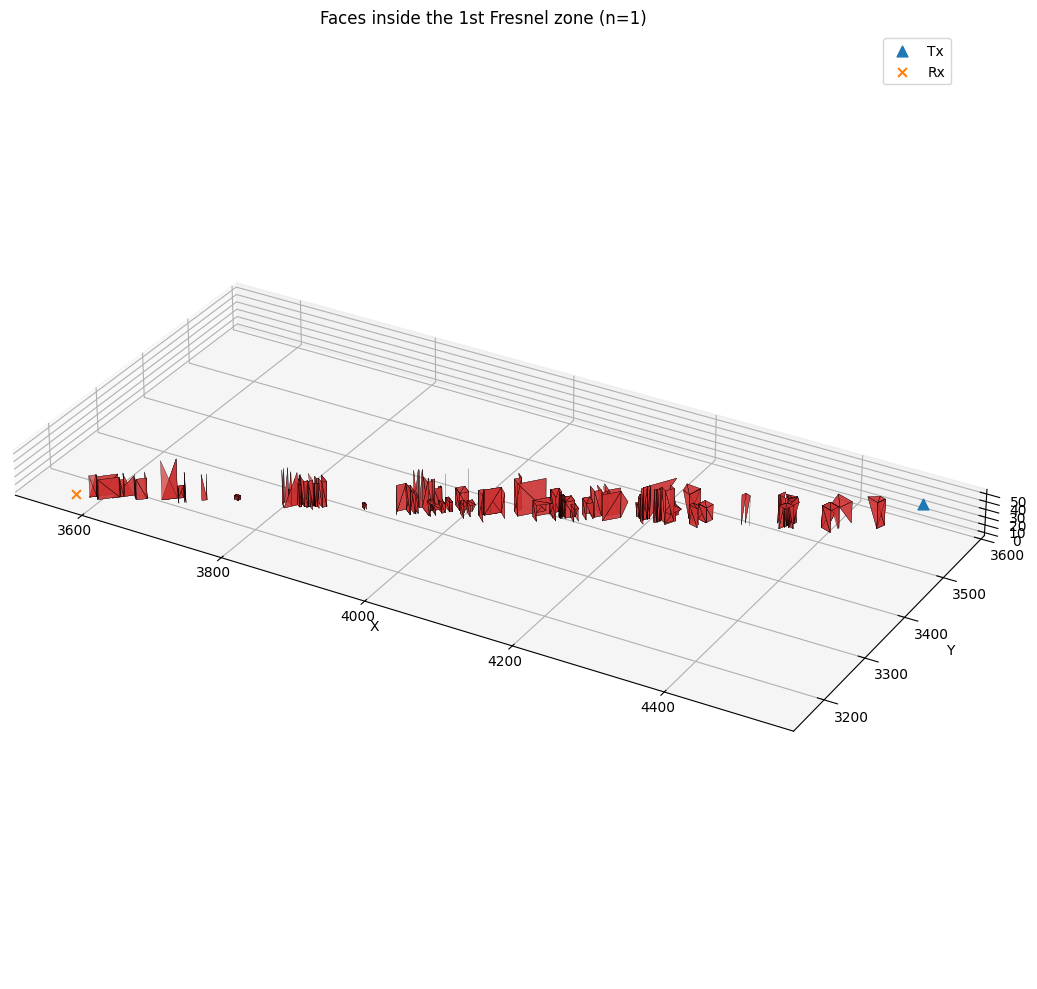

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# --- Inputs you provided ---
Rx = np.array([3.5703125e+03, 3.1575000e+03, 1.5])
Tx = np.array([4497.95852986, 3578.41536661, 33.7])

# --- Frequency (edit this as needed) ---
f_hz = 1.0e9  # 1 GHz
c = 3e8
lam = c / f_hz

# --- Helper: face sampling for robust intersection test ---
def sample_face_points(vertices, faces, mode='verts+centroid+midpoints'):
    """Return (M,K,3) samples per face: vertices (+ centroid + edge midpoints)."""
    v = vertices
    i0, i1, i2 = faces[:, 0], faces[:, 1], faces[:, 2]
    a, b, c_ = v[i0], v[i1], v[i2]
    centroid = (a + b + c_) / 3.0
    if mode == 'verts':
        samples = np.stack([a, b, c_], axis=1)
    elif mode == 'verts+centroid':
        samples = np.stack([a, b, c_, centroid], axis=1)
    elif mode == 'verts+centroid+midpoints':
        ab = 0.5 * (a + b)
        bc = 0.5 * (b + c_)
        ca = 0.5 * (c_ + a)
        samples = np.stack([a, b, c_, centroid, ab, bc, ca], axis=1)
    else:
        raise ValueError("Unknown mode")
    return samples

# --- Fresnel-zone threshold for n=1 (first zone) ---
D = np.linalg.norm(Rx - Tx)
T = D + 1 * lam / 2.0  # n=1

# --- Build samples for each face in your extended submesh ---
V = city_vertices_extended_shifted          # (U,3)
F = city_faces_extended_shifted             # (K,3)
S = sample_face_points(V, F, 'verts+centroid+midpoints')  # (K,7,3)

# --- Inside test: d1 + d2 <= D + λ/2 for ANY sample on the face ---
d1 = np.linalg.norm(S - Tx[None, None, :], axis=2)  # (K,7)
d2 = np.linalg.norm(S - Rx[None, None, :], axis=2)  # (K,7)
inside_face_mask = (d1 + d2) <= (T + 1e-9)
faces_in_idx = np.where(inside_face_mask.any(axis=1))[0]

print(f"Faces intersecting 1st Fresnel zone: {len(faces_in_idx)} / {len(F)}")

# --- Subset for plotting (only faces inside) ---
F_in = F[faces_in_idx]

# --- Plot only the faces inside the 1st Fresnel zone ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.add_collection3d(Poly3DCollection(
    V[F_in],
    facecolor=(0.8, 0.2, 0.2, 0.7),  # red
    edgecolor='k',
    linewidths=0.2
))

# Optionally scatter Tx/Rx
ax.scatter([Tx[0]], [Tx[1]], [Tx[2]], s=60, marker='^', label='Tx')
ax.scatter([Rx[0]], [Rx[1]], [Rx[2]], s=40, marker='x', label='Rx')

# Axes formatting
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Faces inside the 1st Fresnel zone (n=1)')
ax.legend(loc='upper right')

# Fit view to shown geometry
mins = V[F_in].reshape(-1,3).min(axis=0)
maxs = V[F_in].reshape(-1,3).max(axis=0)
ax.set_box_aspect((maxs - mins) / (maxs - mins).max())

plt.tight_layout()
plt.show()

Clipped polygons count: 685 (from 1724880 faces)


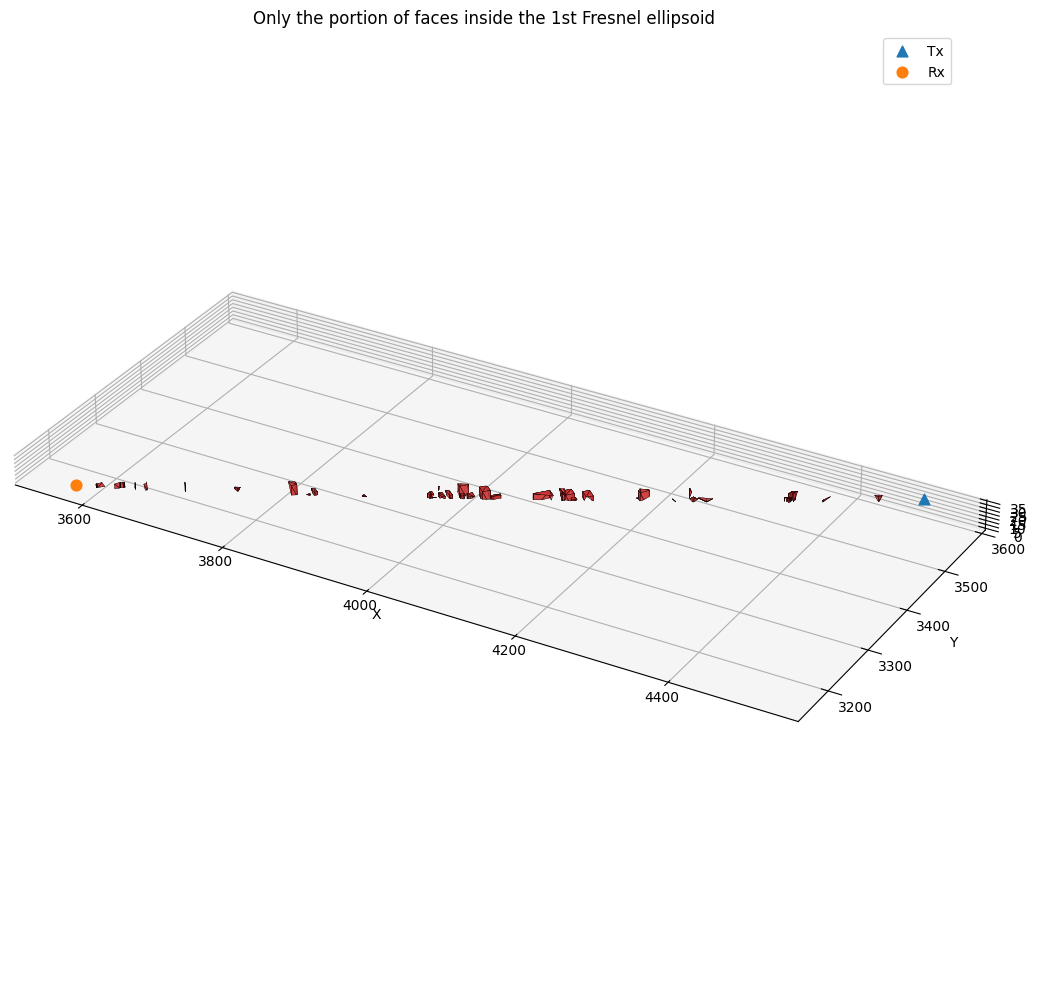

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# === Setup ===
c = 3e8
lam = c / f_hz
D = np.linalg.norm(Rx - Tx)
T = D + lam/2.0  # 1st Fresnel zone

def fresnel_level(p):
    # f(p) <= 0  => inside
    return np.linalg.norm(p - Tx) + np.linalg.norm(p - Rx) - T

# Robust edge intersection with the ellipsoid (implicit surface f(p)=0)
def edge_intersection(p0, p1, f0=None, f1=None, tol=1e-6, max_iter=40):
    if f0 is None: f0 = fresnel_level(p0)
    if f1 is None: f1 = fresnel_level(p1)
    # Ensure the signs differ (or one is ~zero)
    if abs(f0) < tol: return p0
    if abs(f1) < tol: return p1
    if (f0 > 0 and f1 > 0) or (f0 < 0 and f1 < 0):
        return None  # no crossing

    t0, t1 = 0.0, 1.0
    p_lo, p_hi = p0.copy(), p1.copy()
    f_lo, f_hi = f0, f1

    # Bisection
    for _ in range(max_iter):
        tm = 0.5*(t0 + t1)
        pm = p0 + tm*(p1 - p0)
        fm = fresnel_level(pm)
        if abs(fm) < tol:
            return pm
        if (f_lo <= 0 and fm <= 0) or (f_lo >= 0 and fm >= 0):
            t0, p_lo, f_lo = tm, pm, fm
        else:
            t1, p_hi, f_hi = tm, pm, fm
    return p0 + 0.5*(t0 + t1)*(p1 - p0)

def clip_triangle_to_ellipsoid(a, b, c):
    """
    Returns an array of k>=3 vertices (k-gon) that is the portion of triangle abc
    lying inside the ellipsoid, or None if empty. Works by:
    - keeping inside vertices,
    - inserting edge intersections where sign changes,
    - ordering the resulting polygon in the plane of the triangle.
    """
    pts = [a, b, c]
    fvals = [fresnel_level(p) for p in pts]
    inside = [fv <= 0 for fv in fvals]

    # Collect points that are inside + edge intersections
    poly_pts = []

    def add_pt(p):
        poly_pts.append(p)

    # Add inside vertices
    for p, ok in zip(pts, inside):
        if ok:
            add_pt(p)

    # Check each edge for crossing and add intersection points
    edges = [(0,1), (1,2), (2,0)]
    for i, j in edges:
        p0, p1 = pts[i], pts[j]
        f0, f1 = fvals[i], fvals[j]
        inter = edge_intersection(p0, p1, f0, f1)
        if inter is not None:
            add_pt(inter)

    if len(poly_pts) < 3:
        return None

    # Deduplicate nearly coincident points
    uniq = []
    eps = 1e-7
    for p in poly_pts:
        if not any(np.linalg.norm(p - q) < eps for q in uniq):
            uniq.append(p)
    poly = np.array(uniq)
    if len(poly) < 3:
        return None

    # Order points around centroid in the triangle's plane
    centroid = poly.mean(axis=0)

    # Build a stable 2D basis (u,v) in the triangle plane
    # Use original tri normal to define plane
    n = np.cross(b - a, c - a)
    n_norm = np.linalg.norm(n)
    if n_norm < 1e-12:
        # Degenerate triangle; just return convex-hull order in XY as fallback
        rel = poly[:, :2] - centroid[:2]
        ang = np.arctan2(rel[:,1], rel[:,0])
        order = np.argsort(ang)
        return poly[order]

    n = n / n_norm
    # choose u along (b-a), v = n x u
    u = b - a
    u = u / (np.linalg.norm(u) + 1e-15)
    v = np.cross(n, u)

    # angles for ordering
    rel = poly - centroid
    xu = rel @ u
    xv = rel @ v
    ang = np.arctan2(xv, xu)
    order = np.argsort(ang)
    return poly[order]

# Build clipped polygons for all faces
V = city_vertices_extended_shifted
F = city_faces_extended_shifted
clipped_polys = []

for tri in F_in:
    a, b, c_ = V[tri[0]], V[tri[1]], V[tri[2]]
    poly = clip_triangle_to_ellipsoid(a, b, c_)
    if poly is not None:
        clipped_polys.append(poly)

print(f"Clipped polygons count: {len(clipped_polys)} (from {len(F)} faces)")

# --- Plot the clipped parts only ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.add_collection3d(Poly3DCollection(
    clipped_polys,
    facecolor=(0.8, 0.2, 0.2, 0.7),
    edgecolor='k',
    linewidths=0.2
))

ax.scatter([Tx[0]], [Tx[1]], [Tx[2]], s=60, marker='^', label='Tx')
ax.scatter([Rx[0]], [Rx[1]], [Rx[2]], s=60, marker='o', label='Rx')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Only the portion of faces inside the 1st Fresnel ellipsoid')
ax.legend(loc='upper right')

# Fit view to shown geometry
if clipped_polys:
    all_pts = np.concatenate(clipped_polys, axis=0)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    ax.set_box_aspect((maxs - mins) / (maxs - mins).max())

plt.tight_layout()
plt.show()

[Pre-filter] Faces intersecting 1st Fresnel zone: 3144 / 1724880
[Clipping] Polygons produced: 2183 (from 3144 faces)


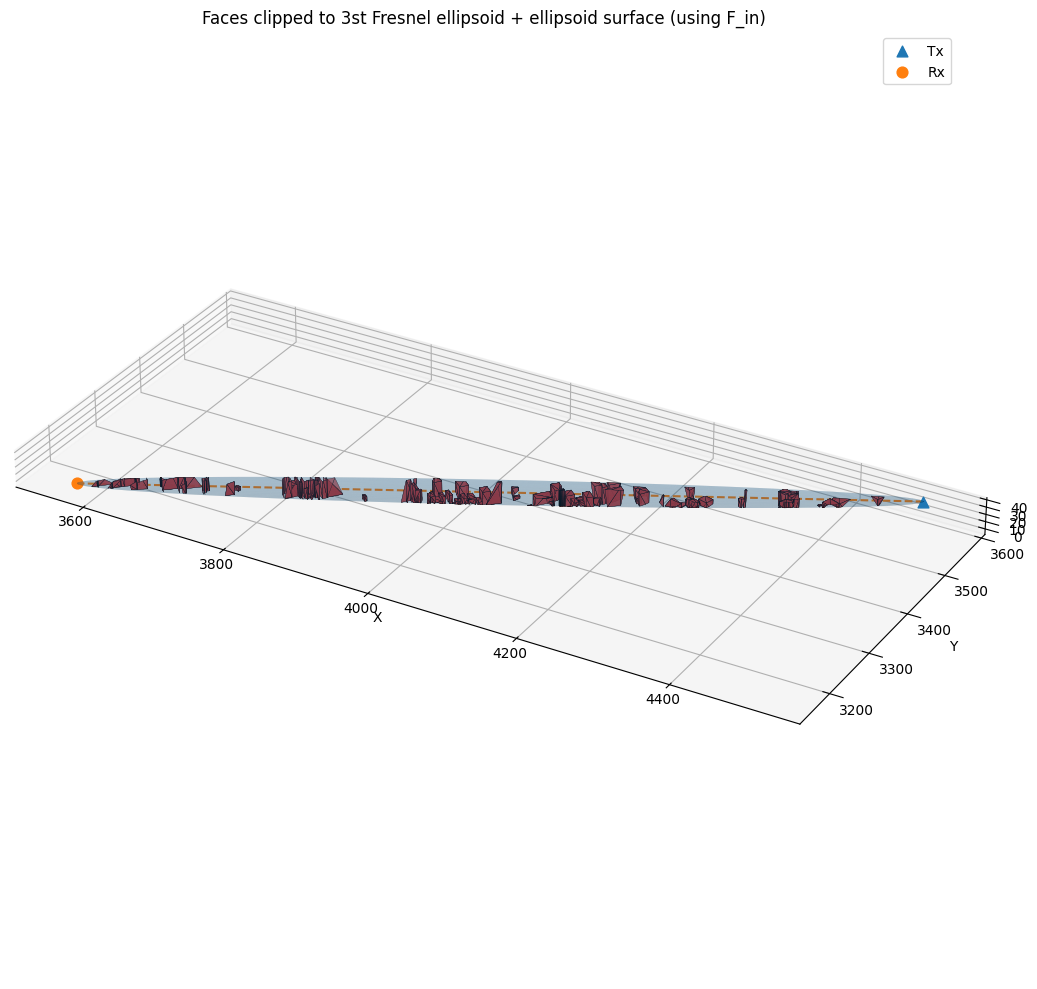

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ===== Inputs =====
# You should already have these in memory (e.g., loaded from your .npz in Colab)
try:
    V = city_vertices_extended_shifted          # (U,3) float
    F = city_faces_extended_shifted             # (K,3) int
except NameError as e:
    raise RuntimeError("Please define city_vertices_extended_shifted and city_faces_extended_shifted first.") from e

try:
    Tx
    Rx
except NameError as e:
    raise RuntimeError("Please define Tx and Rx 3D coordinates first.") from e

# Frequency (Hz). If not defined, default to 1 GHz.
if "f_hz" not in globals():
    f_hz = 1.0e9

# Fresnel zone number (1 = first zone)
n_zone = 3

# ===== Fresnel ellipsoid math =====
c = 3e8
lam = c / f_hz
D = np.linalg.norm(Rx - Tx)                     # Tx–Rx distance
T = D + n_zone * lam / 2.0                      # threshold for nth zone: d1 + d2 <= T

def fresnel_level(p):
    """f(p) <= 0 => inside ellipsoid; f(p) = 0 => boundary."""
    return np.linalg.norm(p - Tx) + np.linalg.norm(p - Rx) - T

# ======== Build F_in (faces that intersect the Fresnel zone) ========
def sample_face_points(vertices, faces, mode='verts+centroid+midpoints'):
    """
    Return (M,K,3) samples per face.
      'verts' -> 3 samples (a,b,c)
      'verts+centroid' -> 4 samples
      'verts+centroid+midpoints' -> 7 samples (robust default)
    """
    v = vertices
    i0, i1, i2 = faces[:,0], faces[:,1], faces[:,2]
    a, b, c_ = v[i0], v[i1], v[i2]
    centroid = (a + b + c_) / 3.0
    if mode == 'verts':
        S = np.stack([a, b, c_], axis=1)
    elif mode == 'verts+centroid':
        S = np.stack([a, b, c_, centroid], axis=1)
    elif mode == 'verts+centroid+midpoints':
        ab = 0.5*(a + b)
        bc = 0.5*(b + c_)
        ca = 0.5*(c_ + a)
        S = np.stack([a, b, c_, centroid, ab, bc, ca], axis=1)
    else:
        raise ValueError("Unknown mode")
    return S

# Sample points on each face
S = sample_face_points(V, F, 'verts+centroid+midpoints')      # (K,7,3)
# Inside test: d1 + d2 <= T for any sample on the face
d1 = np.linalg.norm(S - Tx[None, None, :], axis=2)           # (K,7)
d2 = np.linalg.norm(S - Rx[None, None, :], axis=2)           # (K,7)
inside_face_mask = (d1 + d2) <= (T + 1e-9)
faces_in_idx = np.where(inside_face_mask.any(axis=1))[0]

F_in = F[faces_in_idx]
print(f"[Pre-filter] Faces intersecting 1st Fresnel zone: {len(F_in)} / {len(F)}")

# ======== Precise clipping (triangle ∩ ellipsoid) over F_in only ========
def edge_intersection(p0, p1, f0=None, f1=None, tol=1e-6, max_iter=40):
    """Intersect segment p0->p1 with f(p)=0 using robust bisection, if it crosses."""
    if f0 is None: f0 = fresnel_level(p0)
    if f1 is None: f1 = fresnel_level(p1)
    if abs(f0) < tol: return p0
    if abs(f1) < tol: return p1
    if (f0 > 0 and f1 > 0) or (f0 < 0 and f1 < 0):
        return None  # no crossing

    t0, t1 = 0.0, 1.0
    for _ in range(max_iter):
        tm = 0.5*(t0 + t1)
        pm = p0 + tm*(p1 - p0)
        fm = fresnel_level(pm)
        if abs(fm) < tol:
            return pm
        # keep the half interval containing the root
        if (f0 <= 0 and fm <= 0) or (f0 >= 0 and fm >= 0):
            t0, f0 = tm, fm
        else:
            t1, f1 = tm, fm
    # very close fallback
    return p0 + 0.5*(t0 + t1)*(p1 - p0)

def clip_triangle_to_ellipsoid(a, b, c):
    """
    Return k-gon (k>=3) inside the ellipsoid for triangle (a,b,c); else None.
    """
    pts = [a, b, c]
    fvals = [fresnel_level(p) for p in pts]
    inside = [fv <= 0.0 for fv in fvals]

    poly_pts = []
    # keep inside vertices
    for p, ok in zip(pts, inside):
        if ok:
            poly_pts.append(p)
    # add intersection points where sign changes
    for (i, j) in ((0,1), (1,2), (2,0)):
        inter = edge_intersection(pts[i], pts[j], fvals[i], fvals[j])
        if inter is not None:
            poly_pts.append(inter)

    # need at least a triangle
    eps = 1e-7
    uniq = []
    for p in poly_pts:
        if not any(np.linalg.norm(p - q) < eps for q in uniq):
            uniq.append(p)
    if len(uniq) < 3:
        return None
    poly = np.array(uniq)

    # order vertices by angle in the triangle plane
    centroid = poly.mean(axis=0)
    n = np.cross(b - a, c - a)
    n_norm = np.linalg.norm(n)
    if n_norm < 1e-12:
        # degenerate triangle: order by XY angle
        rel2 = poly[:, :2] - centroid[:2]
        ang = np.arctan2(rel2[:,1], rel2[:,0])
        return poly[np.argsort(ang)]

    n = n / n_norm
    u = b - a; u = u / (np.linalg.norm(u) + 1e-15)
    v = np.cross(n, u)
    rel = poly - centroid
    xu = rel @ u
    xv = rel @ v
    ang = np.arctan2(xv, xu)
    return poly[np.argsort(ang)]

# Clip only F_in
clipped_polys = []
for tri in F_in:
    a, b, c_ = V[tri[0]], V[tri[1]], V[tri[2]]
    poly = clip_triangle_to_ellipsoid(a, b, c_)
    if poly is not None:
        clipped_polys.append(poly)

print(f"[Clipping] Polygons produced: {len(clipped_polys)} (from {len(F_in)} faces)")

# ===== Build & plot the Fresnel ellipsoid surface =====
# Ellipsoid d1 + d2 = T -> semi-axes:
#   a = T/2 (major along Tx→Rx),  b = sqrt(a^2 - (D/2)^2) (two equal minors)
center = 0.5 * (Tx + Rx)
a = T / 2.0
c_focus = D / 2.0
b = np.sqrt(max(a*a - c_focus*c_focus, 0.0))  # numerical guard

# Parametric ellipsoid in local frame
theta = np.linspace(0.0, np.pi, 70)        # polar
phi   = np.linspace(0.0, 2.0*np.pi, 110)   # azimuth
Theta, Phi = np.meshgrid(theta, phi)
Xloc = a * np.cos(Theta)
Yloc = b * np.sin(Theta) * np.cos(Phi)
Zloc = b * np.sin(Theta) * np.sin(Phi)

# Orthonormal basis aligned with link
u_dir = (Rx - Tx) / (D + 1e-15)
tmp = np.array([0.0, 0.0, 1.0]) if abs(np.dot(u_dir, [0,0,1])) < 0.9 else np.array([0.0, 1.0, 0.0])
v_dir = np.cross(u_dir, tmp); v_dir /= (np.linalg.norm(v_dir) + 1e-15)
w_dir = np.cross(u_dir, v_dir)

# Transform to world coords
X = center[0] + Xloc * u_dir[0] + Yloc * v_dir[0] + Zloc * w_dir[0]
Y = center[1] + Xloc * u_dir[1] + Yloc * v_dir[1] + Zloc * w_dir[1]
Z = center[2] + Xloc * u_dir[2] + Yloc * v_dir[2] + Zloc * w_dir[2]

# ===== Plot =====
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 1) Clipped city patches inside the Fresnel zone
if clipped_polys:
    ax.add_collection3d(Poly3DCollection(
        clipped_polys,
        facecolor=(0.8, 0.2, 0.2, 0.7),
        edgecolor='k',
        linewidths=0.2
    ))

# 2) Ellipsoid surface
ax.plot_surface(X, Y, Z, alpha=0.2, linewidth=0, antialiased=True)

# 3) Tx/Rx and link segment
ax.scatter([Tx[0]], [Tx[1]], [Tx[2]], s=60, marker='^', label='Tx')
ax.scatter([Rx[0]], [Rx[1]], [Rx[2]], s=60, marker='o', label='Rx')
ax.plot([Tx[0], Rx[0]], [Tx[1], Rx[1]], [Tx[2], Rx[2]], linestyle='--')

# Axes & view
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title(f'Faces clipped to {n_zone}st Fresnel ellipsoid + ellipsoid surface (using F_in)')
ax.legend(loc='upper right')

# Fit view to shown geometry
all_sets = []
if clipped_polys:
    all_sets.append(np.concatenate(clipped_polys, axis=0))
all_sets.extend([Tx[None, :], Rx[None, :], np.c_[X.ravel(), Y.ravel(), Z.ravel()]])
all_pts = np.concatenate(all_sets, axis=0)
mins = all_pts.min(axis=0); maxs = all_pts.max(axis=0)
span = maxs - mins; span[span == 0] = 1.0
ax.set_box_aspect(span / span.max())

plt.tight_layout()
plt.show()

[Prefilter] Faces intersecting 3rd zone: 3144 / 1724880
[Bands] ≤1st: 685, 1st–2nd: 1501, 2nd–3rd: 2059


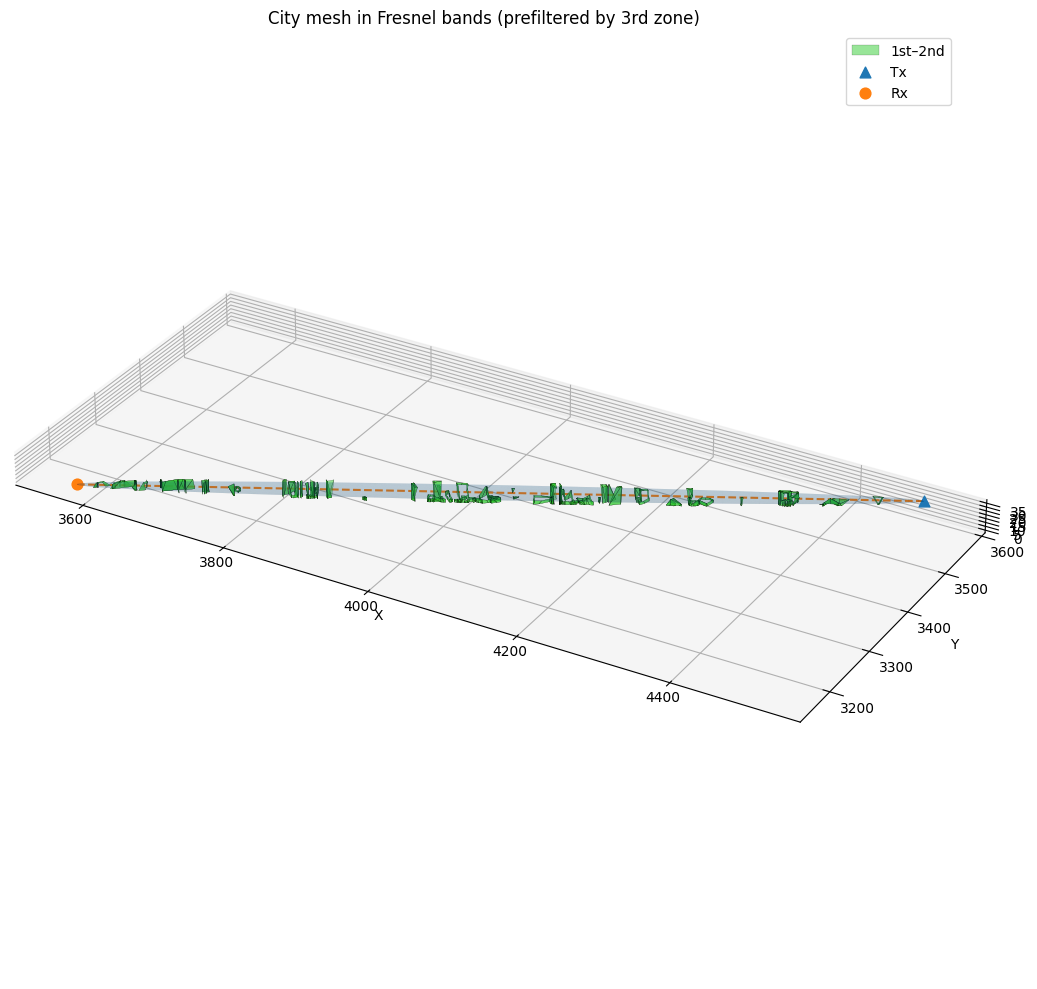

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ===== Inputs (should already exist) =====
try:
    V = city_vertices_extended_shifted          # (U,3)
    F = city_faces_extended_shifted             # (K,3)
except NameError as e:
    raise RuntimeError("Please define city_vertices_extended_shifted and city_faces_extended_shifted first.") from e
try:
    Tx; Rx
except NameError as e:
    raise RuntimeError("Please define Tx and Rx 3D coordinates first.") from e
if "f_hz" not in globals():
    f_hz = 1.0e9

# ===== Fresnel parameters =====
c = 3e8
lam = c / f_hz
D = float(np.linalg.norm(Rx - Tx))

# Thresholds for zones
T1 = D + 1 * lam / 2.0
T2 = D + 2 * lam / 2.0
T3 = D + 3 * lam / 2.0

def level(p, T):
    """f_T(p) <= 0 => inside ellipsoid whose sum-of-distances threshold is T."""
    return np.linalg.norm(p - Tx) + np.linalg.norm(p - Rx) - T

# ---- Robust segment/ellipsoid intersection at given T ----
def edge_intersection_T(p0, p1, T, f0=None, f1=None, tol=1e-6, max_iter=40):
    if f0 is None: f0 = level(p0, T)
    if f1 is None: f1 = level(p1, T)
    if abs(f0) < tol: return p0
    if abs(f1) < tol: return p1
    if (f0 > 0 and f1 > 0) or (f0 < 0 and f1 < 0):
        return None
    t0, t1 = 0.0, 1.0
    for _ in range(max_iter):
        tm = 0.5*(t0 + t1)
        pm = p0 + tm*(p1 - p0)
        fm = level(pm, T)
        if abs(fm) < tol:
            return pm
        if (f0 <= 0 and fm <= 0) or (f0 >= 0 and fm >= 0):
            t0, f0 = tm, fm
        else:
            t1, f1 = tm, fm
    return p0 + 0.5*(t0 + t1)*(p1 - p0)

def order_polygon_in_triangle_plane(poly, a, b, c):
    centroid = poly.mean(axis=0)
    n = np.cross(b - a, c - a)
    n_norm = np.linalg.norm(n)
    if n_norm < 1e-12:
        rel2 = poly[:, :2] - centroid[:2]
        return poly[np.argsort(np.arctan2(rel2[:,1], rel2[:,0]))]
    n = n / n_norm
    u = b - a; u = u / (np.linalg.norm(u) + 1e-15)
    v = np.cross(n, u)
    rel = poly - centroid
    ang = np.arctan2(rel @ v, rel @ u)
    return poly[np.argsort(ang)]

def clip_triangle_inside_T(a, b, c, T):
    """Triangle ∩ {f_T <= 0} -> polygon or None."""
    pts = [a, b, c]
    fvals = [level(p, T) for p in pts]
    inside = [fv <= 0.0 for fv in fvals]
    poly_pts = []
    # keep inside vertices
    for p, ok in zip(pts, inside):
        if ok: poly_pts.append(p)
    # add intersections where sign changes
    for (i,j) in ((0,1),(1,2),(2,0)):
        inter = edge_intersection_T(pts[i], pts[j], T, fvals[i], fvals[j])
        if inter is not None:
            poly_pts.append(inter)
    # dedupe
    eps = 1e-7
    uniq = []
    for p in poly_pts:
        if not any(np.linalg.norm(p - q) < eps for q in uniq):
            uniq.append(p)
    if len(uniq) < 3:
        return None
    return order_polygon_in_triangle_plane(np.array(uniq), a, b, c)

def clip_polygon_against_T(poly, T, keep_sign='<=0'):
    """
    Clip polygon against f_T(p)=0.
      keep_sign '<=0' keeps inside of ellipsoid; '>=0' keeps outside.
    """
    if poly is None or len(poly) < 3:
        return None
    keep_le = (keep_sign == '<=0')
    out = []
    N = len(poly)
    for i in range(N):
        P = poly[i]; Q = poly[(i+1)%N]
        fP = level(P, T); fQ = level(Q, T)
        Pin = (fP <= 0.0) if keep_le else (fP >= 0.0)
        Qin = (fQ <= 0.0) if keep_le else (fQ >= 0.0)
        if Pin and Qin:
            out.append(Q)
        elif Pin and not Qin:
            I = edge_intersection_T(P, Q, T, fP, fQ)
            if I is not None: out.append(I)
        elif (not Pin) and Qin:
            I = edge_intersection_T(P, Q, T, fP, fQ)
            if I is not None: out.append(I)
            out.append(Q)
        # else both out: add nothing
    if len(out) < 3:
        return None
    # dedupe
    eps = 1e-7
    clean = []
    for p in out:
        if not any(np.linalg.norm(p - q) < eps for q in clean):
            clean.append(p)
    return np.asarray(clean) if len(clean) >= 3 else None

# ---------- Prefilter faces using ONLY the 3rd zone ----------
def sample_face_points(vertices, faces):
    v = vertices
    i0, i1, i2 = faces[:,0], faces[:,1], faces[:,2]
    a, b, c_ = v[i0], v[i1], v[i2]
    centroid = (a + b + c_) / 3.0
    ab = 0.5*(a + b)
    bc = 0.5*(b + c_)
    ca = 0.5*(c_ + a)
    return np.stack([a, b, c_, centroid, ab, bc, ca], axis=1)  # (K,7,3)

S = sample_face_points(V, F)          # (K,7,3)
d1 = np.linalg.norm(S - Tx[None,None,:], axis=2)
d2 = np.linalg.norm(S - Rx[None,None,:], axis=2)
mask_T3 = (d1 + d2) <= (T3 + 1e-9)
F_in3 = F[np.where(mask_T3.any(axis=1))[0]]
print(f"[Prefilter] Faces intersecting 3rd zone: {len(F_in3)} / {len(F)}")

# ---------- Build bands over the SAME F_in3 ----------
polys_z1   = []  # ≤ 1st
polys_z12  = []  # 1st–2nd
polys_z23  = []  # 2nd–3rd

for tri in F_in3:
    a, b, c = V[tri[0]], V[tri[1]], V[tri[2]]

    # ≤ 1st zone
    p1 = clip_triangle_inside_T(a, b, c, T1)
    if p1 is not None:
        polys_z1.append(p1)

    # 1st–2nd: (inside T2) AND (outside T1)
    p_to_T2 = clip_triangle_inside_T(a, b, c, T2)
    if p_to_T2 is not None:
        p12 = clip_polygon_against_T(p_to_T2, T1, keep_sign='>=0')
        if p12 is not None:
            polys_z12.append(p12)

    # 2nd–3rd: (inside T3) AND (outside T2)
    p_to_T3 = clip_triangle_inside_T(a, b, c, T3)
    if p_to_T3 is not None:
        p23 = clip_polygon_against_T(p_to_T3, T2, keep_sign='>=0')
        if p23 is not None:
            polys_z23.append(p23)

print(f"[Bands] ≤1st: {len(polys_z1)}, 1st–2nd: {len(polys_z12)}, 2nd–3rd: {len(polys_z23)}")

# ---------- Ellipsoid (1st) for context ----------
center = 0.5*(Tx + Rx)
def ellipsoid_surface(T, n_theta=60, n_phi=96):
    a = T/2.0
    c_focus = D/2.0
    b = np.sqrt(max(a*a - c_focus*c_focus, 0.0))
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    Theta, Phi = np.meshgrid(theta, phi)
    Xloc = a * np.cos(Theta)
    Yloc = b * np.sin(Theta) * np.cos(Phi)
    Zloc = b * np.sin(Theta) * np.sin(Phi)
    u_dir = (Rx - Tx) / (D + 1e-15)
    tmp = np.array([0.0, 0.0, 1.0]) if abs(np.dot(u_dir, [0,0,1])) < 0.9 else np.array([0.0, 1.0, 0.0])
    v_dir = np.cross(u_dir, tmp); v_dir /= (np.linalg.norm(v_dir) + 1e-15)
    w_dir = np.cross(u_dir, v_dir)
    X = center[0] + Xloc*u_dir[0] + Yloc*v_dir[0] + Zloc*w_dir[0]
    Y = center[1] + Xloc*u_dir[1] + Yloc*v_dir[1] + Zloc*w_dir[1]
    Z = center[2] + Xloc*u_dir[2] + Yloc*v_dir[2] + Zloc*w_dir[2]
    return X, Y, Z

X1, Y1, Z1 = ellipsoid_surface(T1)

# ---------- Plot ----------
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

#if polys_z23:
#    ax.add_collection3d(Poly3DCollection(polys_z23, facecolor=(0.2,0.2,0.8,0.35), edgecolor='k', linewidths=0.1, label='2nd–3rd'))
if polys_z12:
    ax.add_collection3d(Poly3DCollection(polys_z12, facecolor=(0.2,0.8,0.2,0.5), edgecolor='k', linewidths=0.1, label='1st–2nd'))
#if polys_z1:
#    ax.add_collection3d(Poly3DCollection(polys_z1,  facecolor=(0.8,0.2,0.2,0.7),  edgecolor='k', linewidths=0.2, label='≤ 1st'))

ax.plot_surface(X1, Y1, Z1, alpha=0.15, linewidth=0, antialiased=True)

ax.scatter([Tx[0]],[Tx[1]],[Tx[2]], s=60, marker='^', label='Tx')
ax.scatter([Rx[0]],[Rx[1]],[Rx[2]], s=60, marker='o', label='Rx')
ax.plot([Tx[0],Rx[0]], [Tx[1],Rx[1]], [Tx[2],Rx[2]], linestyle='--')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('City mesh in Fresnel bands (prefiltered by 3rd zone)')
ax.legend(loc='upper right')

# Fit view
all_sets = []
for L in (polys_z1, polys_z12, polys_z23):
    if L: all_sets.append(np.concatenate(L, axis=0))
all_sets.extend([Tx[None,:], Rx[None,:], np.c_[X1.ravel(),Y1.ravel(),Z1.ravel()]])
all_pts = np.concatenate(all_sets, axis=0)
mins = all_pts.min(axis=0); maxs = all_pts.max(axis=0)
span = maxs - mins; span[span == 0] = 1.0
ax.set_box_aspect(span / span.max())

plt.tight_layout()
plt.show()

Faces touching Tx/Rx 50 m spheres: 1995 / 1724880


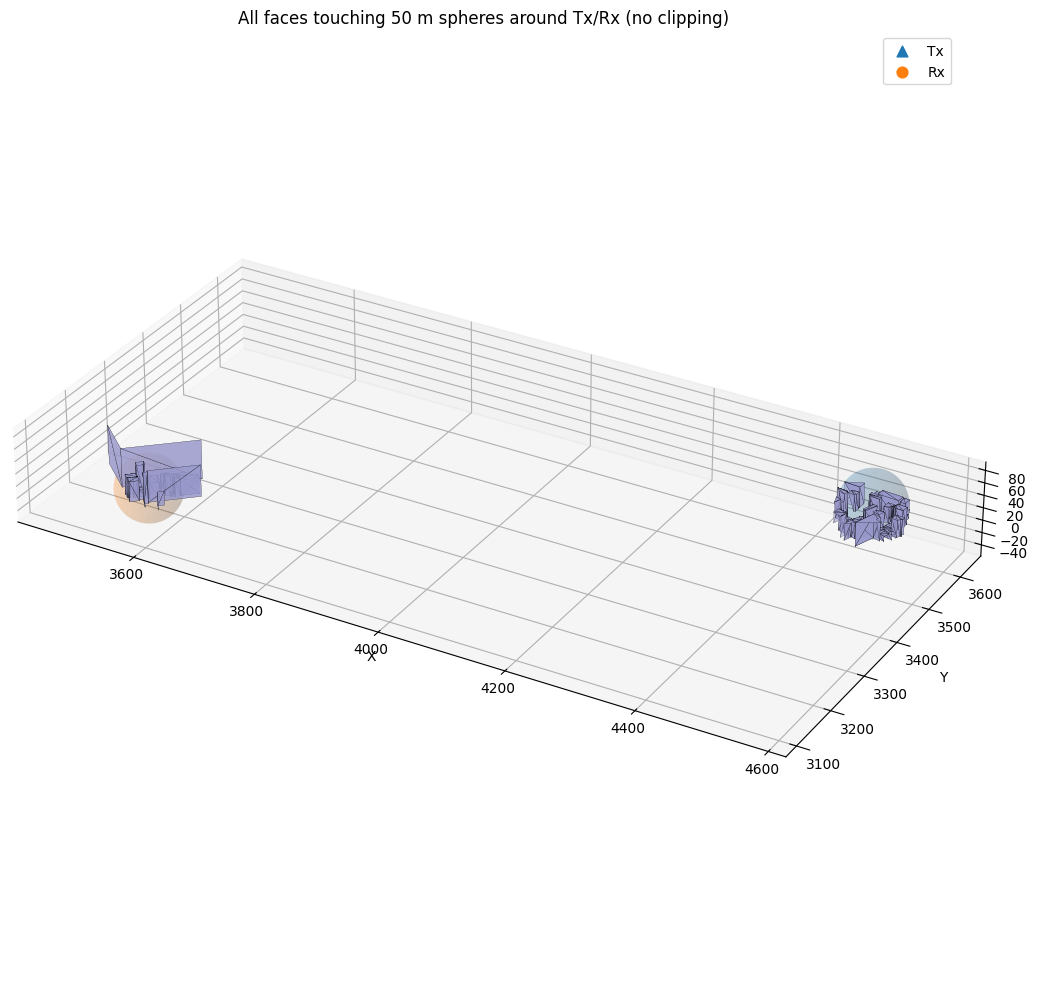

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# --- Inputs expected in memory ---
# V = city_vertices_extended_shifted  # (U,3)
# F = city_faces_extended_shifted     # (K,3)
# Tx, Rx = np.array([...])            # (3,)
R = 50.0  # radius (meters)
eps = 1e-9

# --- Fast prefilter: pick faces that have ANY sample point inside either sphere ---
def sample_face_points(vertices, faces):
    v = vertices
    i0, i1, i2 = faces[:,0], faces[:,1], faces[:,2]
    a, b, c_ = v[i0], v[i1], v[i2]
    centroid = (a + b + c_) / 3.0
    ab = 0.5*(a + b)
    bc = 0.5*(b + c_)
    ca = 0.5*(c_ + a)
    return np.stack([a, b, c_, centroid, ab, bc, ca], axis=1)  # (K,7,3)

S = sample_face_points(V, F)  # (K,7,3)

d_tx = np.linalg.norm(S - Tx[None, None, :], axis=2)  # (K,7)
d_rx = np.linalg.norm(S - Rx[None, None, :], axis=2)  # (K,7)

mask_tx   = (d_tx <= (R + eps)).any(axis=1)
mask_rx   = (d_rx <= (R + eps)).any(axis=1)
mask_union = mask_tx | mask_rx

F_in_ball = F[np.where(mask_union)[0]]
print(f"Faces touching Tx/Rx 50 m spheres: {len(F_in_ball)} / {len(F)}")

# --- Optional: build sphere surfaces for context (not required) ---
def sphere_surface(C, R, n_theta=40, n_phi=64):
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    Theta, Phi = np.meshgrid(theta, phi)
    X = C[0] + R*np.sin(Theta)*np.cos(Phi)
    Y = C[1] + R*np.sin(Theta)*np.sin(Phi)
    Z = C[2] + R*np.cos(Theta)
    return X, Y, Z

Xtx, Ytx, Ztx = sphere_surface(Tx, R)
Xrx, Yrx, Zrx = sphere_surface(Rx, R)

# --- Plot the faces (no clipping) ---
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

# All selected faces in one collection
ax.add_collection3d(Poly3DCollection(
    V[F_in_ball],
    facecolor=(0.6, 0.6, 0.8, 0.6),  # light bluish
    edgecolor='k',
    linewidths=0.1
))

# Tx/Rx spheres for context (optional)
ax.plot_surface(Xtx, Ytx, Ztx, alpha=0.15, linewidth=0, antialiased=True)
ax.plot_surface(Xrx, Yrx, Zrx, alpha=0.15, linewidth=0, antialiased=True)

# Tx/Rx markers
ax.scatter([Tx[0]],[Tx[1]],[Tx[2]], s=60, marker='^', label='Tx')
ax.scatter([Rx[0]],[Rx[1]],[Rx[2]], s=60, marker='o', label='Rx')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('All faces touching 50 m spheres around Tx/Rx (no clipping)')
ax.legend(loc='upper right')

# Fit view to shown geometry
all_pts = np.concatenate([V[F_in_ball].reshape(-1,3),
                          Tx[None,:], Rx[None,:],
                          np.c_[Xtx.ravel(),Ytx.ravel(),Ztx.ravel()],
                          np.c_[Xrx.ravel(),Yrx.ravel(),Zrx.ravel()]], axis=0)
mins = all_pts.min(axis=0); maxs = all_pts.max(axis=0)
span = maxs - mins; span[span == 0] = 1.0
ax.set_box_aspect(span / span.max())

plt.tight_layout()
plt.show()

[Prefilter] Faces touching Tx/Rx spheres: 1995 / 1724880
[Clip] polygons in Tx-ball: 1167, in Rx-ball: 474


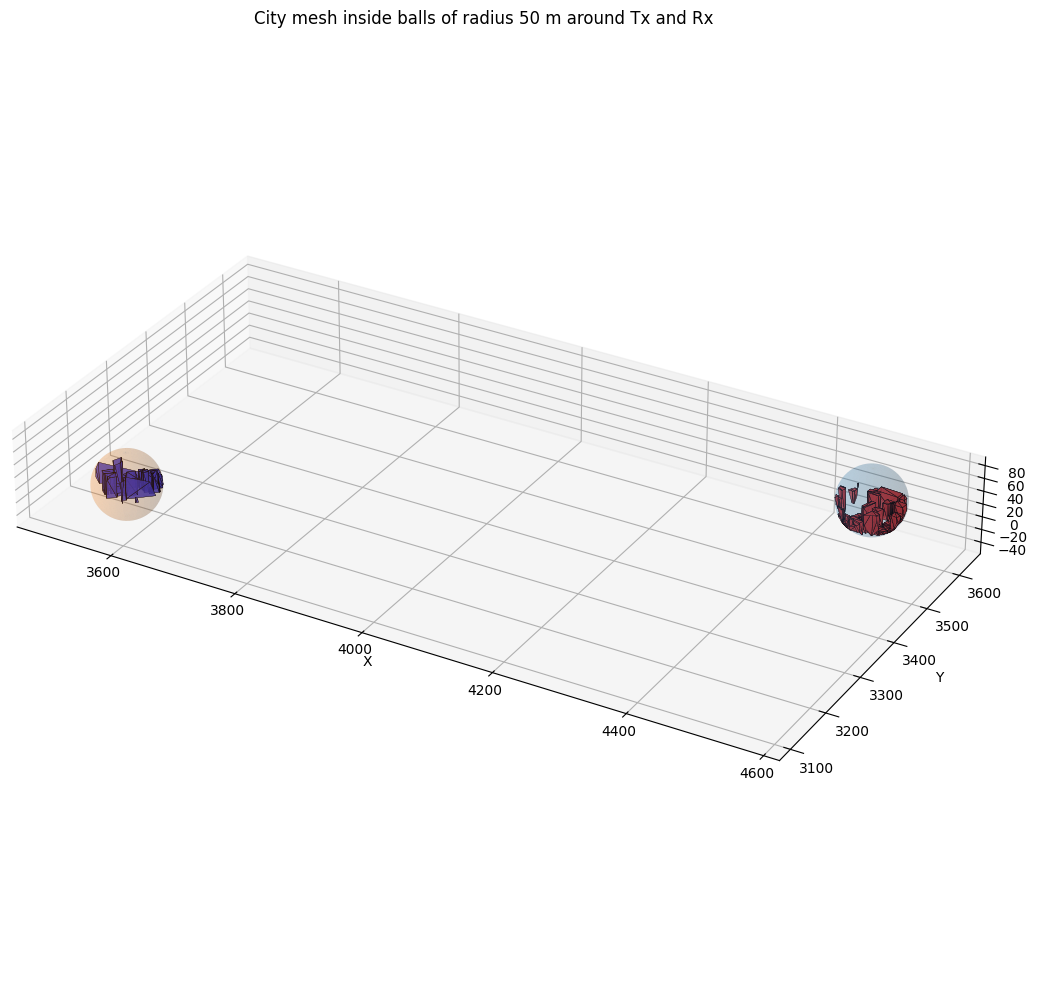

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ===== Inputs expected in memory =====
# V = city_vertices_extended_shifted   # (U,3)
# F = city_faces_extended_shifted      # (K,3)
# Tx, Rx (3,)
# If f_hz was defined earlier it's fine; not needed here.

R = 50.0  # radius (meters)
eps = 1e-9

# ---------- Helpers: sampling like before for fast prefilter ----------
def sample_face_points(vertices, faces):
    v = vertices
    i0, i1, i2 = faces[:,0], faces[:,1], faces[:,2]
    a, b, c_ = v[i0], v[i1], v[i2]
    centroid = (a + b + c_) / 3.0
    ab = 0.5*(a + b)
    bc = 0.5*(b + c_)
    ca = 0.5*(c_ + a)
    return np.stack([a, b, c_, centroid, ab, bc, ca], axis=1)  # (K,7,3)

S = sample_face_points(V, F)   # (K,7,3)

# inside sphere if ||p - C|| <= R
d_tx = np.linalg.norm(S - Tx[None,None,:], axis=2)  # (K,7)
d_rx = np.linalg.norm(S - Rx[None,None,:], axis=2)  # (K,7)

mask_tx = (d_tx <= (R + eps)).any(axis=1)
mask_rx = (d_rx <= (R + eps)).any(axis=1)
mask_union = mask_tx | mask_rx

F_in_ball = F[np.where(mask_union)[0]]
print(f"[Prefilter] Faces touching Tx/Rx spheres: {len(F_in_ball)} / {len(F)}")

# ---------- Precise clipping: triangle ∩ sphere(C,R) ----------
def sphere_level(p, C, R):
    return np.linalg.norm(p - C) - R   # <=0 is inside

def edge_intersection_sphere(p0, p1, C, R, f0=None, f1=None, tol=1e-6, max_iter=40):
    if f0 is None: f0 = sphere_level(p0, C, R)
    if f1 is None: f1 = sphere_level(p1, C, R)
    if abs(f0) < tol: return p0
    if abs(f1) < tol: return p1
    if (f0 > 0 and f1 > 0) or (f0 < 0 and f1 < 0):
        return None  # no crossing
    t0, t1 = 0.0, 1.0
    for _ in range(max_iter):
        tm = 0.5*(t0 + t1)
        pm = p0 + tm*(p1 - p0)
        fm = sphere_level(pm, C, R)
        if abs(fm) < tol:
            return pm
        if (f0 <= 0 and fm <= 0) or (f0 >= 0 and fm >= 0):
            t0, f0 = tm, fm
        else:
            t1, f1 = tm, fm
    return p0 + 0.5*(t0 + t1)*(p1 - p0)

def order_polygon_in_triangle_plane(poly, a, b, c):
    centroid = poly.mean(axis=0)
    n = np.cross(b - a, c - a)
    n_norm = np.linalg.norm(n)
    if n_norm < 1e-12:
        rel2 = poly[:, :2] - centroid[:2]
        ang = np.arctan2(rel2[:,1], rel2[:,0])
        return poly[np.argsort(ang)]
    n = n / n_norm
    u = b - a; u = u / (np.linalg.norm(u) + 1e-15)
    v = np.cross(n, u)
    rel = poly - centroid
    ang = np.arctan2(rel @ v, rel @ u)
    return poly[np.argsort(ang)]

def clip_triangle_inside_sphere(a, b, c, C, R):
    pts = [a, b, c]
    fvals = [sphere_level(p, C, R) for p in pts]
    inside = [fv <= 0.0 for fv in fvals]

    poly_pts = []
    for p, ok in zip(pts, inside):
        if ok: poly_pts.append(p)

    for (i,j) in ((0,1),(1,2),(2,0)):
        inter = edge_intersection_sphere(pts[i], pts[j], C, R, fvals[i], fvals[j])
        if inter is not None:
            poly_pts.append(inter)

    # dedupe + validate
    e = 1e-7
    uniq = []
    for p in poly_pts:
        if not any(np.linalg.norm(p - q) < e for q in uniq):
            uniq.append(p)
    if len(uniq) < 3:
        return None
    poly = np.array(uniq)
    return order_polygon_in_triangle_plane(poly, a, b, c)

# ---------- Build polygons for each sphere, then take their union (as a set) ----------
polys_tx = []
polys_rx = []
for tri in F_in_ball:
    a, b, c = V[tri[0]], V[tri[1]], V[tri[2]]
    ptx = clip_triangle_inside_sphere(a, b, c, Tx, R)
    if ptx is not None:
        polys_tx.append(ptx)
    prx = clip_triangle_inside_sphere(a, b, c, Rx, R)
    if prx is not None:
        polys_rx.append(prx)

print(f"[Clip] polygons in Tx-ball: {len(polys_tx)}, in Rx-ball: {len(polys_rx)}")

# NOTE: We simply plot both lists; overlap will be drawn twice (usually fine for visualization).
# If you need a true polygon union, that’s a heavier boolean-op step.

# ---------- Optional: draw the two spheres for context ----------
def sphere_surface(C, R, n_theta=40, n_phi=64):
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    Theta, Phi = np.meshgrid(theta, phi)
    X = C[0] + R*np.sin(Theta)*np.cos(Phi)
    Y = C[1] + R*np.sin(Theta)*np.sin(Phi)
    Z = C[2] + R*np.cos(Theta)
    return X, Y, Z

Xtx, Ytx, Ztx = sphere_surface(Tx, R)
Xrx, Yrx, Zrx = sphere_surface(Rx, R)

# ---------- Plot ----------
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

if polys_tx:
    ax.add_collection3d(Poly3DCollection(polys_tx, facecolor=(0.8,0.2,0.2,0.6), edgecolor='k', linewidths=0.2, label='Tx ball'))
if polys_rx:
    ax.add_collection3d(Poly3DCollection(polys_rx, facecolor=(0.2,0.2,0.8,0.6), edgecolor='k', linewidths=0.2, label='Rx ball'))

# Spheres (light)
ax.plot_surface(Xtx, Ytx, Ztx, alpha=0.15, linewidth=0, antialiased=True)
ax.plot_surface(Xrx, Yrx, Zrx, alpha=0.15, linewidth=0, antialiased=True)

# Markers
ax.scatter([Tx[0]],[Tx[1]],[Tx[2]], s=60, marker='^', label='Tx')
ax.scatter([Rx[0]],[Rx[1]],[Rx[2]], s=60, marker='o', label='Rx')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('City mesh inside balls of radius 50 m around Tx and Rx')

# Fit view
all_sets = []
if polys_tx: all_sets.append(np.concatenate(polys_tx, axis=0))
if polys_rx: all_sets.append(np.concatenate(polys_rx, axis=0))
all_sets.extend([Tx[None,:], Rx[None,:], np.c_[Xtx.ravel(),Ytx.ravel(),Ztx.ravel()], np.c_[Xrx.ravel(),Yrx.ravel(),Zrx.ravel()]])
all_pts = np.concatenate(all_sets, axis=0)
mins = all_pts.min(axis=0); maxs = all_pts.max(axis=0)
span = maxs - mins; span[span == 0] = 1.0
ax.set_box_aspect(span / span.max())

plt.tight_layout()
plt.show()


[Prefilter] Faces intersecting elevated 1st Fresnel zone: 1028 / 1724880
[Clip] polygons inside elevated 1st zone: 518


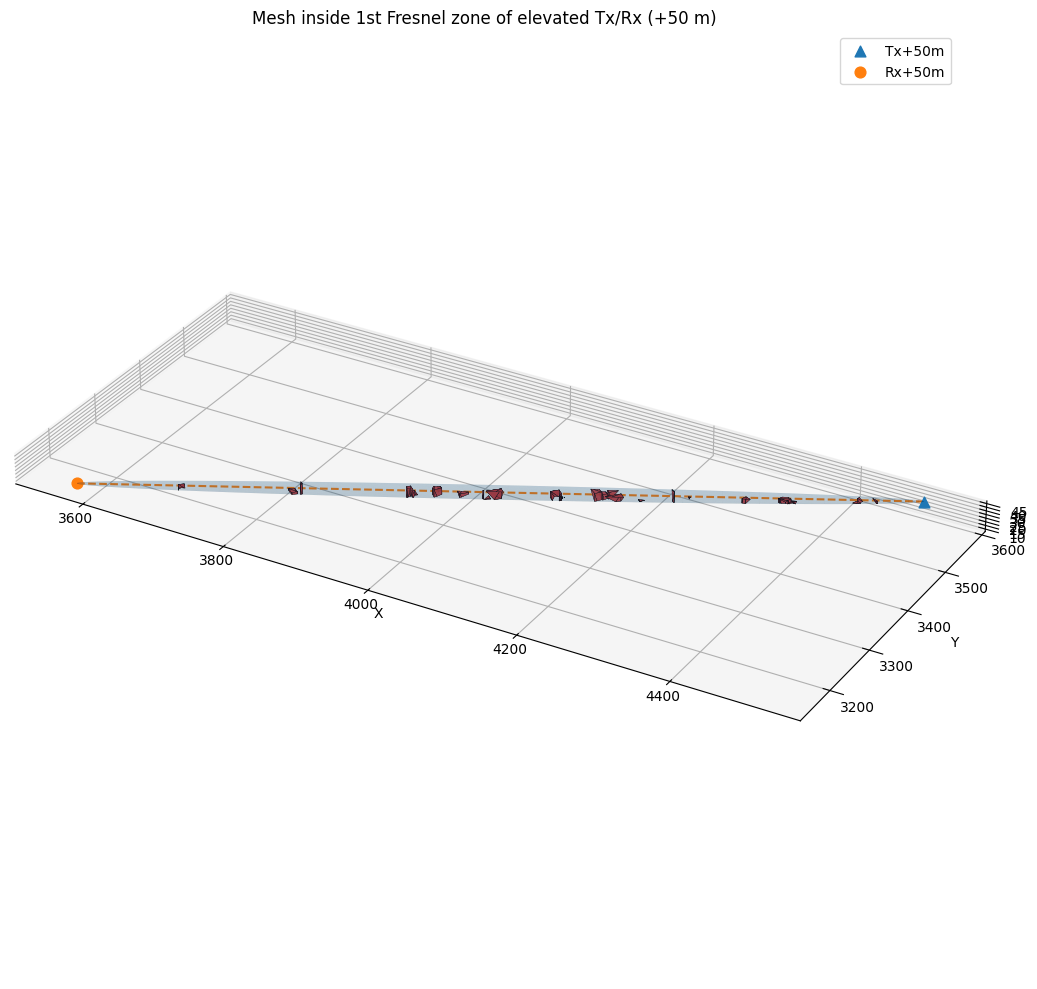

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ===== Inputs expected in memory =====
# V = city_vertices_extended_shifted  # (U,3) float
# F = city_faces_extended_shifted     # (K,3) int
# Tx, Rx (3,) and f_hz (Hz)

# 0) Elevate Tx/Rx by +50 m in Z
Tx_elev = Tx.copy(); Tx_elev[2] += 10.0
Rx_elev = Rx.copy(); Rx_elev[2] += 10.0

# 1) Fresnel params for the *elevated* link
c = 3e8
lam = c / float(f_hz)
D  = float(np.linalg.norm(Rx_elev - Tx_elev))
T1 = D + 1 * lam / 2.0  # 1st Fresnel zone threshold

def level_T1(p):
    """f(p) <= 0 means inside the 1st Fresnel ellipsoid for the elevated link."""
    return np.linalg.norm(p - Tx_elev) + np.linalg.norm(p - Rx_elev) - T1

# 2) Robust segment–ellipsoid intersection (bisection on f=0)
def edge_intersection_T1(p0, p1, f0=None, f1=None, tol=1e-6, max_iter=40):
    if f0 is None: f0 = level_T1(p0)
    if f1 is None: f1 = level_T1(p1)
    if abs(f0) < tol: return p0
    if abs(f1) < tol: return p1
    if (f0 > 0 and f1 > 0) or (f0 < 0 and f1 < 0):
        return None
    t0, t1 = 0.0, 1.0
    for _ in range(max_iter):
        tm = 0.5*(t0 + t1)
        pm = p0 + tm*(p1 - p0)
        fm = level_T1(pm)
        if abs(fm) < tol:
            return pm
        if (f0 <= 0 and fm <= 0) or (f0 >= 0 and fm >= 0):
            t0, f0 = tm, fm
        else:
            t1, f1 = tm, fm
    return p0 + 0.5*(t0 + t1)*(p1 - p0)

def order_polygon_in_triangle_plane(poly, a, b, c):
    centroid = poly.mean(axis=0)
    n = np.cross(b - a, c - a)
    n_norm = np.linalg.norm(n)
    if n_norm < 1e-12:
        rel2 = poly[:, :2] - centroid[:2]
        return poly[np.argsort(np.arctan2(rel2[:,1], rel2[:,0]))]
    n = n / n_norm
    u = b - a; u = u / (np.linalg.norm(u) + 1e-15)
    v = np.cross(n, u)
    rel = poly - centroid
    ang = np.arctan2(rel @ v, rel @ u)
    return poly[np.argsort(ang)]

def clip_triangle_inside_T1(a, b, c):
    """Triangle ∩ {f<=0} for the elevated-link 1st Fresnel ellipsoid."""
    pts = [a, b, c]
    fvals = [level_T1(p) for p in pts]
    inside = [fv <= 0.0 for fv in fvals]

    poly_pts = []
    for p, ok in zip(pts, inside):
        if ok:
            poly_pts.append(p)

    for (i,j) in ((0,1),(1,2),(2,0)):
        inter = edge_intersection_T1(pts[i], pts[j], fvals[i], fvals[j])
        if inter is not None:
            poly_pts.append(inter)

    # dedupe + validate
    eps = 1e-7
    uniq = []
    for p in poly_pts:
        if not any(np.linalg.norm(p - q) < eps for q in uniq):
            uniq.append(p)
    if len(uniq) < 3:
        return None
    return order_polygon_in_triangle_plane(np.array(uniq), a, b, c)

# 3) Prefilter faces (fast) using vertices+centroid+midpoints against T1
def sample_face_points(vertices, faces):
    v = vertices
    i0, i1, i2 = faces[:,0], faces[:,1], faces[:,2]
    a, b, c_ = v[i0], v[i1], v[i2]
    centroid = (a + b + c_) / 3.0
    ab = 0.5*(a + b)
    bc = 0.5*(b + c_)
    ca = 0.5*(c_ + a)
    return np.stack([a, b, c_, centroid, ab, bc, ca], axis=1)  # (K,7,3)

S   = sample_face_points(V, F)  # (K,7,3)
d1  = np.linalg.norm(S - Tx_elev[None,None,:], axis=2)
d2  = np.linalg.norm(S - Rx_elev[None,None,:], axis=2)
mask = (d1 + d2) <= (T1 + 1e-9)
F_in = F[np.where(mask.any(axis=1))[0]]
print(f"[Prefilter] Faces intersecting elevated 1st Fresnel zone: {len(F_in)} / {len(F)}")

# 4) Exact clipping over F_in
clipped_polys = []
for tri in F_in:
    a, b, c_ = V[tri[0]], V[tri[1]], V[tri[2]]
    poly = clip_triangle_inside_T1(a, b, c_)
    if poly is not None:
        clipped_polys.append(poly)

print(f"[Clip] polygons inside elevated 1st zone: {len(clipped_polys)}")

# 5) (Optional) Plot ellipsoid for context
def fresnel_ellipsoid_surface(T, Tx_, Rx_, n_theta=60, n_phi=96):
    D_ = float(np.linalg.norm(Rx_ - Tx_))
    a = T/2.0
    c_focus = D_/2.0
    b = np.sqrt(max(a*a - c_focus*c_focus, 0.0))
    center = 0.5*(Tx_ + Rx_)
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    Theta, Phi = np.meshgrid(theta, phi)
    Xloc = a * np.cos(Theta)
    Yloc = b * np.sin(Theta) * np.cos(Phi)
    Zloc = b * np.sin(Theta) * np.sin(Phi)
    u_dir = (Rx_ - Tx_) / (D_ + 1e-15)
    tmp = np.array([0.0,0.0,1.0]) if abs(np.dot(u_dir, [0,0,1])) < 0.9 else np.array([0.0,1.0,0.0])
    v_dir = np.cross(u_dir, tmp); v_dir /= (np.linalg.norm(v_dir) + 1e-15)
    w_dir = np.cross(u_dir, v_dir)
    X = center[0] + Xloc*u_dir[0] + Yloc*v_dir[0] + Zloc*w_dir[0]
    Y = center[1] + Xloc*u_dir[1] + Yloc*v_dir[1] + Zloc*w_dir[1]
    Z = center[2] + Xloc*u_dir[2] + Yloc*v_dir[2] + Zloc*w_dir[2]
    return X, Y, Z

X1, Y1, Z1 = fresnel_ellipsoid_surface(T1, Tx_elev, Rx_elev)

# 6) Plot
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

if clipped_polys:
    ax.add_collection3d(Poly3DCollection(
        clipped_polys,
        facecolor=(0.8, 0.2, 0.2, 0.7),
        edgecolor='k',
        linewidths=0.2
    ))

ax.plot_surface(X1, Y1, Z1, alpha=0.15, linewidth=0, antialiased=True)

# Markers for elevated link (and dashed segment)
ax.scatter([Tx_elev[0]],[Tx_elev[1]],[Tx_elev[2]], s=60, marker='^', label='Tx+50m')
ax.scatter([Rx_elev[0]],[Rx_elev[1]],[Rx_elev[2]], s=60, marker='o', label='Rx+50m')
ax.plot([Tx_elev[0], Rx_elev[0]], [Tx_elev[1], Rx_elev[1]], [Tx_elev[2], Rx_elev[2]], linestyle='--')

# (Optional) also show original endpoints for comparison
# ax.scatter([Tx[0]],[Tx[1]],[Tx[2]], s=40, marker='^', c='k', label='Tx (orig)')
# ax.scatter([Rx[0]],[Rx[1]],[Rx[2]], s=40, marker='o', c='k', label='Rx (orig)')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Mesh inside 1st Fresnel zone of elevated Tx/Rx (+50 m)')
ax.legend(loc='upper right')

# Fit view
all_sets = []
if clipped_polys:
    all_sets.append(np.concatenate(clipped_polys, axis=0))
all_sets.extend([Tx_elev[None,:], Rx_elev[None,:], np.c_[X1.ravel(),Y1.ravel(),Z1.ravel()]])
all_pts = np.concatenate(all_sets, axis=0)
mins = all_pts.min(axis=0); maxs = all_pts.max(axis=0)
span = maxs - mins; span[span == 0] = 1.0
ax.set_box_aspect(span / span.max())

plt.tight_layout()
plt.show()